In [1]:
!python --version
import os
import warnings
print (os.environ['CONDA_DEFAULT_ENV'])

#suppress warnings
warnings.filterwarnings('ignore')

from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()

client

Python 3.10.16
nutrient-effect-on-tex


<Client: 'tcp://127.0.0.1:42643' processes=4 threads=8, memory=62.53 GiB>

In [2]:
### use numba to speed up the code
from numba import jit

@jit(nopython=True)
def fast_function():
    pass


### Use Memory-Efficient Pandas Operations
import pandas as pd
pd.options.mode.chained_assignment = None  # Disable warnings
pd.set_option("display.float_format", "{:.2f}".format)  # Reduce memory usage



# 1. Workbook setups

## 1.1 Import packages

In [3]:
import pandas as pd
import numpy as np
import xarray as xr
xr.set_options(file_cache_maxsize=10)

import scipy as scipy
from scipy import stats
import math
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import proplot as plot
import cartopy.crs as ccrs

import shapefile as shp
from shapely.geometry import Point, Polygon
import shapely
from geopy.distance import distance, Distance, lonlat

from matplotlib import font_manager
font_manager.findfont("TeX Gyre Heros")
mpl.rcParams.update({'font.sans-serif':'TeX Gyre Heros',
                    'font.weight': 'normal',
                    'axes.labelweight': 'normal',
                    'axes.titleweight': 'normal',
                    'pdf.fonttype':42,
                    'ps.fonttype':42
                     })

import string
import os
import requests
import io
from tqdm import tqdm
import time
import h5py
import scipy.io

## 1.2 Miscellaneous codes

In [4]:
def round_to_nearest_half_int(num):
    return round(num * 2) / 2

def getClosestPoint_fromLineString(LineString_input,point1):
    if "MultiLineString" in str(type(LineString_input)):
        multiLineString = LineString_input
        len_multiLineString = len(multiLineString.geoms)
        idxMin = np.array([multiLineString.geoms[i].distance(point1) for i in range(len_multiLineString)]).argmin()
        
        LineString = multiLineString.geoms[idxMin]
    elif "Polygon" in str(type(LineString_input)):
        
        polygon_input = LineString_input
        LineString = polygon_input.exterior
        
    else:
        LineString = LineString_input
        
    Coords = LineString.coords
    x, y = Coords.xy

    coords_df = pd.DataFrame({'LON':x,'LAT':y})
    coords_df['LAT_diff'] = abs(point1.y-coords_df.LAT)
    coords_df['LON_diff'] = abs(point1.x-coords_df.LON)
    coords_df['LONLAT_diff_sum'] = coords_df['LAT_diff']+coords_df['LON_diff']
    lat2,lon2 = coords_df.LAT.iloc[coords_df.LONLAT_diff_sum.idxmin()],coords_df.LON.iloc[coords_df.LONLAT_diff_sum.idxmin()]
    point2 = Point(lon2,lat2)
    return point2

def distance_haversine(origin, destination, output_unit='km'):
    import math
    lon1, lat1 = origin
    lon2, lat2 = destination
    
    if output_unit=='km':
        radius = 6371
    elif output_unit=='mi':
        radius = 3956
    elif output_unit=='m':
        radius = 6371000
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

# Define usefull functions:
def vrange(V): # Return the array value range
    return [np.min(V),np.max(V)]
def vrangec(V): # Return the array value centered range 
    xl = np.max(np.abs(vrange(V)))
    return np.array([-xl,xl])

def nonnan_gradient(array, axis=None, edge_order=1):
  """Computes the gradient of an array, ignoring NaN values.

  Args:
    array: An N-dimensional array containing samples of a scalar function.
    axis: The axis along which to compute the gradient. If None, the gradient
      is computed for all axes.
    edge_order: The order of the accuracy of the approximation at the edges of
      the array.

  Returns:
    An N-dimensional array or a list of N-dimensional arrays representing the
    gradient.
  """

  # Create a mask of non-NaN values.
  mask = np.isfinite(array)

  # Compute the gradient of the masked array.
  gradient = np.gradient(array, axis=axis, edge_order=edge_order)

  # Set the gradient to zero wherever the mask is False.
  for i in range(len(gradient)):
    gradient[i][~mask] = 0

  return gradient

## 1.3 Dictionaries

In [5]:
ringNumbers_dict_zhang16 = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':4, 
    'fGDGT_cren':4,
    'reported_1292_iso':4,
    'fGDGT_cren_prime':4,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}

ringNumbers_dict_revised = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':5, 
    'fGDGT_cren':5,
    'reported_1292_iso':5,
    'fGDGT_cren_prime':5,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}

def label_pvalues(x):
    if x<0.001:
        return r'$\it{P}$<.001'
    elif x<0.01:
        return r'$\it{P}$<.01'
    elif x<0.05:
        return r'$\it{P}$<.05'
    elif x<0.1:
        return r'$\it{P}$<.1'
    elif x>=0.1:
        return r'$\it{P}$>.1'


## 1.4 Set local paths

In [6]:
# set the path to local folder other than github

### 1.4.1 Local path on PC
local_documents_path = '/home/ronnie/Documents' ### this is the path when code is run on Linux

### 1.4.2 Path to github folder
gitpath_idx = os.getcwd().find('nutrient-effect-on-TEX')+len('nutrient-effect-on-TEX')
local_github_path = os.getcwd()[:gitpath_idx]

### 1.4.3 Path to OneDrive folder
local_onedrive_path = '/home/ronnie/OneDrive'

# 2. Import data

## 2.1 Processed coretop_df_full


In [7]:
local_github_path

'/home/ronnie/Documents/GitHub/nutrient-effect-on-TEX'

In [8]:
fpath = fr'{local_github_path}/spreadsheets'
fname = 'ds03_processed_coretop_tex.csv'

coretop_df = pd.read_csv(f'{fpath}/{fname}')
coretop_df

sampleID  index_column           core_name core_type  sample_depth_start  \
0     RR00001  JET_RR_00001          GeoB7702-3        GC                5.00   
1     RR00002  JET_RR_00002       KNR195-5 MC11        MC                6.00   
2     RR00003  JET_RR_00003       KNR195-5 MC12        MC                0.00   
3     RR00004  JET_RR_00004       KNR195-5 MC16        MC                0.00   
4     RR00005  JET_RR_00005       KNR195-5 MC18        MC                4.00   
...       ...           ...                 ...       ...                 ...   
2097  RR02100  JET_RR_02100        AMD17_BB2_BC       NaN                 NaN   
2098  RR02101  JET_RR_02101    AMD17_CASQ1_BC-4       NaN                 NaN   
2099  RR02102  JET_RR_02102        AMD17_176_BC       NaN                 NaN   
2100  RR02103  JET_RR_02103        AMD17_8.1_BC       NaN                 NaN   
2101  RR02104  JET_RR_02104  AMD17_Disko_Fan_BC       NaN                 NaN   

      sample_depth_end  Latitude  Longitude  modernWaterDepth  TEX86  ...  \
0                 6.00     31.65      34.07            562.00   0.66  ...   
1                 8.00     -1.53     -86.79           2288.00   0.60  ...   
2                 1.00     -3.71     -81.12            378.00   0.57  ...   
3                 1.00     -3.75     -81.14            379.00   0.57  ...   
4                 6.00     -3.97     -81.31           1024.00   0.60  ...   
...                ...       ...        ...               ...    ...  ...   
2097               NaN     72.75     -67.02           2373.00   0.35  ...   
2098               NaN     71.41     -70.89            702.00   0.35  ...   
2099               NaN     69.60     -65.40            267.00   0.40  ...   
2100               NaN     69.41     -64.40           1054.00   0.32  ...   
2101               NaN     67.97     -59.49           1012.00   0.38  ...   

      thermocline_depth  thermocline_T  thermocline_T_depthIntegral  SSN  \
0                 55.00          19.01                        21.59 0.09   
1                 25.00          20.86                        22.52 4.09   
2                 15.00          20.73                        22.09 3.52   
3                 15.00          20.58                        22.04 4.42   
4                 15.00          20.12                        21.32 4.33   
...                 ...            ...                          ...  ...   
2097              20.00          -0.94                        -0.38 2.86   
2098               5.00          -0.07                         0.54 3.00   
2099              10.00          -0.88                        -0.63 3.09   
2100              10.00          -0.84                        -0.53 2.98   
2101              10.00           0.09                         0.32 2.78   

      thermocline_nitrate  thermocline_nitrate_depthIntegral  region_ID  \
0                    0.00                               0.03        NaN   
1                    8.30                               5.32      10.00   
2                    5.80                               4.21        NaN   
3                    7.11                               5.38        NaN   
4                    6.46                               4.97      10.00   
...                   ...                                ...        ...   
2097                 3.63                               3.06      60.00   
2098                 2.95                               2.97      60.00   
2099                 3.16                               3.11      60.00   
2100                 3.04                               3.00      60.00   
2101                 2.83                               2.80      60.00   

                   regionName pred_tex tex_residuals  
0                         NaN     0.59          0.07  
1     East Equatorial Pacific     0.60          0.00  
2                         NaN     0.60         -0.03  
3                         NaN     0.60         -0.02  
4     East Equator

In [9]:
import matplotlib.colors as mcolors
##### concatenate three colormaps

colors1 = plot.get_colors('tab10')
colors2 = plot.get_colors('tab20b')
colors3 = plot.get_colors('538')
colors4 = plot.get_colors('tab20c')
colors5 = plot.get_colors('bmh')

combined_cmap = np.concatenate((colors1,colors2,colors3,colors4,colors5))
extended_cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap',combined_cmap)
#########
region_list_full = coretop_df['regionName'].unique()
color_list_full = plot.get_colors(extended_cmap,len(region_list_full))

region_color_dict_full = dict(zip(region_list_full,color_list_full))
region_color_dict_full

region_color_dict_full_rgb = {k:mpl.colors.to_rgba(v) for k,v in region_color_dict_full.items()}
region_color_dict_full_rgb

{nan: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 'East Equatorial Pacific': (0.984313725490196,
  0.5019607843137255,
  0.058823529411764705,
  1.0),
 'Mozambique Channel': (0.2, 0.6078431372549019, 0.17254901960784313, 1.0),
 'Pacific-Southern Ocean': (0.8235294117647058,
  0.16862745098039217,
  0.19215686274509805,
  1.0),
 'Tasman-Antarctica 140E Transect': (0.5686274509803921,
  0.3803921568627451,
  0.592156862745098,
  1.0),
 'NZ-SW Pacific': (0.6705882352941176,
  0.3843137254901961,
  0.4588235294117647,
  1.0),
 'Equatorial Pacific': (0.7450980392156863,
  0.47843137254901963,
  0.6627450980392157,
  1.0),
 'West Equatorial Pacific': (0.592156862745098,
  0.592156862745098,
  0.3568627450980392,
  1.0),
 'Tonga-Tropical South Pacific': (0.3058823529411765,
  0.7450980392156863,
  0.5843137254901961,
  1.0),
 'South China Sea': (0.1803921568627451,
  0.39215686274509803,
  0.5803921568627451,
  1.0),
 'Chilean Offshore': (0.29411764705882354,
  0.3019

In [10]:
regionName_df = coretop_df.pivot_table(index=('region_ID','regionName'),values='TEX86',aggfunc='count').reset_index()[['region_ID','regionName']]
regionID_to_regionName_dict = dict(zip(regionName_df['region_ID'],regionName_df['regionName']))
regionID_to_regionName_dict


{1.0: 'Amundsen Sea',
 2.0: 'Arabian Sea',
 3.0: 'Arctic Ocean',
 4.0: 'Baltic Sea',
 5.0: 'Bering Sea',
 6.0: 'Black Sea',
 7.0: 'Chilean Offshore',
 8.0: 'Chukchi Sea',
 9.0: 'Drake Passage',
 10.0: 'East Equatorial Pacific',
 11.0: 'Eastern Indian Ocean (Offshore Indonesia)',
 12.0: 'Eastern North America Offshore',
 13.0: 'Eastern South America Offshore',
 14.0: 'Greenland Sea',
 15.0: 'Gulf of Aqaba',
 16.0: 'Gulf of California',
 17.0: 'Gulf of Mexico',
 18.0: 'Hudson Bay',
 19.0: 'Indian Ocean Gyre',
 20.0: 'Indonesian Throughflow',
 21.0: 'Japan Sea',
 22.0: 'Kara Sea',
 23.0: 'Laptev Sea',
 24.0: 'Mediterranean',
 25.0: 'Mozambique Channel',
 26.0: 'North Atlantic',
 27.0: 'North Sea',
 28.0: 'Northern Pacific',
 29.0: 'NZ-SW Pacific',
 30.0: 'Pacific-Southern Ocean',
 31.0: 'Red Sea',
 32.0: 'Ross Sea',
 33.0: 'Santa Barbara Bay',
 34.0: 'SE Pacific',
 35.0: 'Sea of Okhotsk',
 36.0: 'South Africa Offshore',
 37.0: 'South Atlantic Gyre',
 38.0: 'South China Sea',
 39.0: 'South

## 2.2 Calculated ocean products

### 2.2.1 WOA23 thermocline-integrated temperatures and thermocline depths

In [11]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds06_calculated_ocean_properties.nc'

t_sf2tc_da = xr.open_dataset(f'{fpath}/{fname}',decode_times=False).t_sf2tc_avg
t_sf2tc_da

<xarray.DataArray 't_sf2tc_avg' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

In [12]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds06_calculated_ocean_properties.nc'

thermocline_depth_da = xr.open_dataset(os.path.join(fpath,fname),decode_times=False).tc_depth
thermocline_depth_da

<xarray.DataArray 'tc_depth' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

### 2.2.2 CMEMS thermocline-integrated nitrate concentrations

In [13]:
### thermocline depthIntegral Nitrate
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds06_calculated_ocean_properties.nc'

thermocline_nitrate_da = xr.open_dataset(os.path.join(fpath,fname),decode_times=False).no3_sf2tc_avg
thermocline_nitrate_da

<xarray.DataArray 'no3_sf2tc_avg' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

## 2.3 Gridded TEX

In [14]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds04_gridded_coretop_tex.nc'
gridded_coretop_ds = xr.open_dataset(os.path.join(fpath,fname))
gridded_coretop_ds

<xarray.Dataset>
Dimensions:        (lat: 720, lon: 1440)
Coordinates:
  * lat            (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    region_ID      (lon, lat) float64 ...
    tex_count      (lon, lat) float64 ...
    tex_median     (lon, lat) float64 ...
    tex_mean       (lon, lat) float64 ...
    tex_std        (lon, lat) float64 ...
    tex_residuals  (lon, lat) float64 ...
Attributes:
    title:             Gridded coretop TEX86 data
    long_name:         statistics of TEX86 for each grid cell with the same l...
    units:             TEX86 [unitless], thermocline-integrated T [degC], dep...
    summary:           This dataset contains climatological annual means (199...
    data_sources:      Global Ocean Biogeochemistry Hindcast (CMEMS); World O...
    processing_level:  Derived product
    history:           Computed from the global compilation of core-top GDGT ...
    references:        This study

## 2.4 Gridded amOxRate data

In [15]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds05_gridded_AOM_ds.nc'
merged_ammOxR_gridded_ds = xr.open_dataset(os.path.join(fpath,fname))
merged_ammOxR_gridded_ds

<xarray.Dataset>
Dimensions:           (lat: 720, lon: 1440, depth: 55)
Coordinates:
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth             (depth) float32 0.0 5.0 10.0 ... 2.5e+03 3e+03 3.5e+03
Data variables: (12/16)
    ammOxRate_count   (lat, lon, depth) float64 ...
    ammOxRate_median  (lat, lon, depth) float64 ...
    ammOxRate_mean    (lat, lon, depth) float64 ...
    ammOxRate_std     (lat, lon, depth) float64 ...
    NH4_count         (lat, lon, depth) float64 ...
    NH4_median        (lat, lon, depth) float64 ...
    ...                ...
    NO2_mean          (lat, lon, depth) float64 ...
    NO2_std           (lat, lon, depth) float64 ...
    NO3_count         (lat, lon, depth) float64 ...
    NO3_median        (lat, lon, depth) float64 ...
    NO3_mean          (lat, lon, depth) float64 ...
    NO3_std           (lat, lon, depth) float64 ...
Attributes:
    title:             Gridded Ammonia Oxidation Data
    summary:           This dataset contains gridded ammonia oxidation data f...
    data_sources:      Global Ocean Ammonia Oxidation Database (Tang et al. 2...
    processing_level:  Derived product
    history:           Gridded from the original dataset by interpolating to ...
    Conventions:       CF-1.7
    references:        Tang et al. 2023

## 2.5 Global nitrification database by Tang et al. (2023)

In [16]:
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = r'Weiyi23_EarthSystSciData_nitrification_database.xlsx'

global_AOA_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='ammonia oxidizer')
global_AOA_df = global_AOA_df.rename(
    columns={
        'Depth (m)': 'Depth',
        'shallow clade AOA (copies L-1)': 'shallow_clade_AOA_copiesL', 
        'deep clade AOA (copies L-1)': 'deep_clade_AOA_copiesL',
        'total AOA (copies L-1)': 'total_AOA_copiesL', 
        'Thaumarchaeota 16S rRNA (copies L-1)': 'Thaum_16S_rRNA_copiesL',
        ' βAOB (copies L-1)': 'beta_AOB_copiesL', 
        'shallow clade AOA transcript (copies L-1)': 'shallow_clade_AOA_transcript_copiesL',
        'deep clade AOA transcript (copies L-1)': 'deep_clade_AOA_transcript_copiesL',
        'total AOA transcript (copies L-1)': 'total_AOA_transcript_copiesL', 
        ' βAOB transcript (copies L-1)': 'beta_AOB_transcript_copiesL',
        'PAR (μmol Einstein m-2 s-1)': 'PAR', 
        'Light level (%)': 'light_level', 
        'Temperature (°C)': 'insituT',
        'Salinity (psu)': 'insituS', 
        'Potential density (kg m-3)': 'insituSigmaT', 
        'Ammonium+ammonia (μM)': 'NH4_uM',
        'Nitrite (μM)': 'NO2_uM', 
        'Nitrate (μM)': 'NO3_uM', 
        'O2 (μM)': 'insituOxy'}
    )
global_AOA_df

Data source          data_source           Date   \
0     Agogue et al., 2008. Nature  Agogue et al., 2008  2002 September   
1     Agogue et al., 2008. Nature  Agogue et al., 2008  2002 September   
2     Agogue et al., 2008. Nature  Agogue et al., 2008  2002 September   
3     Agogue et al., 2008. Nature  Agogue et al., 2008  2002 September   
4     Agogue et al., 2008. Nature  Agogue et al., 2008  2002 September   
...                           ...                  ...             ...   
2244    Zhang et al., 2020. PNAS.   Zhang et al., 2020      2015 April   
2245    Zhang et al., 2020. PNAS.   Zhang et al., 2020      2015 April   
2246    Zhang et al., 2020. PNAS.   Zhang et al., 2020      2015 April   
2247    Zhang et al., 2020. PNAS.   Zhang et al., 2020      2015 April   
2248    Zhang et al., 2020. PNAS.   Zhang et al., 2020      2015 April   

      Latitude  Longitude   Depth shallow_clade_AOA_copiesL  \
0        61.63     -20.82 2071.00                   2360000   
1        61.63     -20.82 1633.00                 498000.00   
2        61.63     -20.82 1014.00                   2390000   
3        61.63     -20.82  498.00                   4680000   
4        61.63     -20.82   99.00                   7080000   
...        ...        ...     ...                       ...   
2244     30.00     147.00  500.00                       NaN   
2245     30.00     147.00  650.00                       NaN   
2246     30.00     147.00  750.00                       NaN   
2247     30.00     147.00  800.00                       NaN   
2248     30.00     147.00 1000.00                       NaN   

     deep_clade_AOA_copiesL total_AOA_copiesL Thaum_16S_rRNA_copiesL  ... PAR  \
0                       NaN               NaN               78400000  ... NaN   
1                       NaN               NaN            13900000.00  ... NaN   
2                       NaN               NaN              135000000  ... NaN   
3                       NaN               NaN               39900000  ... NaN   
4                       NaN               NaN            63100000.00  ... NaN   
...                     ...               ...                    ...  ...  ..   
2244                    NaN            623000              969342.77  ... NaN   
2245                    NaN           1620000             2356267.47  ... NaN   
2246                    NaN           1460000             3740288.19  ... NaN   
2247                    NaN           1360000             2532082.05  ... NaN   
2248                    NaN            467000              414540.39  ... NaN   

      light_level  insituT insituS insituSigmaT  NH4_uM NO2_uM NO3_uM  pH  \
0             NaN     2.42   34.98        27.92     NaN    NaN    NaN NaN   
1             NaN     3.26   34.95        27.82     NaN    NaN    NaN NaN   
2             NaN     5.55   35.06        27.66     NaN    NaN    NaN NaN   
3             NaN     7.83   35.20        27.45     NaN    NaN    NaN NaN   
4             NaN     9.09   35.23        27.28     NaN    NaN    NaN NaN   
...           ...      ...     ...          ...     ...    ...    ...  ..   
2244          NaN      NaN     NaN          NaN     NaN    NaN    NaN NaN   
2245          NaN      NaN     NaN          NaN     NaN    NaN    NaN NaN   
2246          NaN      NaN     NaN          NaN     NaN    NaN    NaN NaN   
2247          NaN      NaN     NaN          NaN     NaN    NaN    NaN NaN   
2248          NaN      NaN     NaN          NaN     NaN    NaN    NaN NaN   

      insituOxy  
0        292.30  
1        287.40  
2        247.80  
3        265.90  
4        264.20  
...         ...  
2244        NaN  
2245        NaN  
2246        NaN  
2247        NaN  
2248        NaN  

[2249 rows x 25 columns]

In [18]:
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = r'Weiyi23_EarthSystSciData_nitrification_database.xlsx'

global_AOM_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='volumetric ammonia oxidation')
global_AOM_df = global_AOM_df.rename(
    columns={
        'Depth (m)':'Depth',
        'Rate (nmol N L-1 d-1)':'ammoniaOxidationRate', 
        'Standard deviation of rate (nmol N L-1 d-1)':'AOR_std',
        'PAR (μmol Einstein m-2 s-1)':'PAR',
        'Light level (%)':'light_level',
        'Temperature (°C)':'insituT',
        'Salinity (psu)':'insituS',
        'Potential density (kg m-3)':'insituSigmaT',
        'Ammonium+ammonia (μM)':'NH4_uM',
        'Nitrite (μM)':'NO2_uM',
        'Nitrate (μM)':'NO3_uM',
        'O2 (μM)':'insituOxy'}
    )
global_AOM_df = global_AOM_df.replace(
    {'NM':np.nan,
     'BDL':np.nan,}
)

In [19]:
global_AOM_df['thermocline_depth'] = np.nan

for i in range(len(global_AOM_df)):
    lookup_lat = global_AOM_df['Latitude'][i]
    lookup_lon = global_AOM_df['Longitude'][i]
    
    try:
        thermocline_depth_tmp = thermocline_depth_da.sel(lat=lookup_lat,lon=lookup_lon,method='nearest').values
        global_AOM_df['thermocline_depth'][i] = thermocline_depth_tmp
        
    except:
        continue
    

In [20]:
global_AOM_df['thermocline_depth_position'] = global_AOM_df['Depth']-global_AOM_df['thermocline_depth']

## 2.6 Global sedimentary d15N database by NICOPP (Tesdal et al., 2013)

https://www.ncei.noaa.gov/access/paleo-search/study/14114

### 2.6.1 Coretop dataset

In [21]:
fpath = fr'{local_github_path}/spreadsheets/published_data/NICOPP_d15Nsed_database'
fname = 'NICOPP_coretop_published_130307.mat'

mat_cortop = scipy.io.loadmat(os.path.join(fpath,fname))
print(mat_cortop.keys())
print(mat_cortop['__header__'])

dict_keys(['__header__', '__version__', '__globals__', 'ctop_pub'])
b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Mar  7 20:13:16 2013'


In [22]:

df_tmp = []
features = ['name','region','ref',
            'lat','lon','depth','d15N',]
for i in range(len(mat_cortop['ctop_pub'][0][0][0])):
    for feature in features:
        if ('name' in feature) or ('region' in feature) or ('ref' in feature):
            try:
                sel_feature = (mat_cortop['ctop_pub'][feature][0][0][i])[0][0]
            except:
                sel_feature = np.nan
        else:
            try:
                sel_feature = (mat_cortop['ctop_pub'][feature][0][0][i])[0]
            except:
                sel_feature = np.nan
        df_tmp.append(sel_feature)
        

### convert df_tmp into a dataframe with 7 columns
coretop_d15N_df = pd.DataFrame(np.reshape(df_tmp, (2176,7)),columns=features)
coretop_d15N_df

### covert datatype of columns
coretop_d15N_df = coretop_d15N_df.astype({'lat':float,'lon':float,'depth':float,'d15N':float})
coretop_d15N_df


name           region                       ref    lat  \
0            ODP 1228  Eastern Pacific   Agnihotri et al. (2006) -11.06   
1            ODP 1229   Iberian Margin  Alt-Epping et al. (2007)  38.63   
2            ODP 1230   Iberian Margin  Alt-Epping et al. (2007)  38.62   
3            ODP 1231   Iberian Margin  Alt-Epping et al. (2007)  38.69   
4            ODP 1232   Iberian Margin  Alt-Epping et al. (2007)  38.65   
...               ...              ...                       ...    ...   
2171  EW0408-084 MC-7   Gulf of Alaska    Walinsky et al. (2009)  59.53   
2172  EW0408-091 MC-8   Gulf of Alaska    Walinsky et al. (2009)  59.65   
2173  EW0408-094 MC-8   Gulf of Alaska    Walinsky et al. (2009)  60.66   
2174  EW0408-097 MC-8   Gulf of Alaska    Walinsky et al. (2009)  60.56   
2175  EW0408-101 MC-8   Gulf of Alaska    Walinsky et al. (2009)  60.15   

         lon  depth  d15N  
0     -78.08 273.00  5.35  
1      -9.45    NaN  5.60  
2      -9.51 102.00  5.80  
3      -9.26  19.00  6.30  
4      -9.42  54.00  6.10  
...      ...    ...   ...  
2171 -144.13 686.00  3.30  
2172 -145.15 198.00  2.50  
2173 -147.71 744.00  3.70  
2174 -146.77 401.00  4.20  
2175 -145.66 125.00  3.70  

[2176 rows x 7 columns]

In [23]:
### gridded coretop d15N
mid_lat_array = thermocline_depth_da.lat.values
mid_lon_array = thermocline_depth_da.lon.values

coretop_d15N_df['match_lat'] = [mid_lat_array[np.abs(mid_lat_array-lat).argmin()] for lat in coretop_d15N_df['lat']]
coretop_d15N_df['match_lon'] = [mid_lon_array[np.abs(mid_lon_array-lon).argmin()] for lon in coretop_d15N_df['lon']]

features = ['match_lat','match_lon','d15N']
pregridded_coretop_d15N_df = coretop_d15N_df[features]
pregridded_coretop_d15N_df = pregridded_coretop_d15N_df.dropna().reset_index(drop=True)

new_features = ['d15N_count','d15N_median','d15N_mean','d15N_std']
agg_func_list = ['count','median','mean','std']
for i, new_feature in enumerate(features):
    pregridded_coretop_d15N_df[new_features[i]] = pregridded_coretop_d15N_df.groupby([
        'match_lat','match_lon'])[new_feature].transform(agg_func_list[i])
    
pregridded_coretop_d15N_df = pregridded_coretop_d15N_df.drop_duplicates(
    subset=['match_lat','match_lon'],keep='first').reset_index(drop=True)

coretop_gridded_d15N_da = xr.Dataset.from_dataframe(pregridded_coretop_d15N_df.set_index(['match_lat','match_lon']))
coretop_gridded_d15N_da = coretop_gridded_d15N_da.rename({'match_lon':'lon','match_lat':'lat'})
## nan mask
# coretop_gridded_d15N_da = coretop_gridded_d15N_da.where(coretop_gridded_d15N_da['d15N_count']>1)
coretop_gridded_d15N_da

    
### combine all dataarrays into a single dataset
SST_da = thermocline_depth_da
coretop_gridded_d15N_ds = xr.merge([SST_da,coretop_gridded_d15N_da]).drop_vars(['tc_depth'])
coretop_gridded_d15N_ds

<xarray.Dataset>
Dimensions:      (lat: 720, lon: 1440)
Coordinates:
  * lat          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    d15N         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    d15N_count   (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    d15N_median  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    d15N_mean    (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

### 2.6.2 Downcore dataset

In [24]:
fpath = fr'{local_github_path}/spreadsheets/published_data/NICOPP_d15Nsed_database'
fname = 'NICOPP_downcore_published_130307.mat'

mat_data = scipy.io.loadmat(os.path.join(fpath,fname))
print(mat_data.keys())
print(mat_data['__header__'])

dict_keys(['__header__', '__version__', '__globals__', 'core_pub'])
b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Mar  7 13:22:48 2013'


In [25]:
tmp_df = []
for i in range(len(mat_data['core_pub']['name'][0])):
    core_name = np.squeeze(mat_data['core_pub']['name'][0][i])
    core_lat = np.squeeze(mat_data['core_pub']['lat'][0][i])
    core_lon = np.squeeze(mat_data['core_pub']['lon'][0][i])
    core_depth = np.squeeze(mat_data['core_pub']['depth'][0][i])
    try:
        core_depth = np.atleast_1d(core_depth).astype(float)[0]
    except:
        core_depth = np.nan
    core_ref = np.squeeze(mat_data['core_pub']['ref'][0][i])
    core_acidified = np.squeeze(mat_data['core_pub']['acidified'][0][i])
    
    ### check if age and d15N data are available for the core
    age_len = len(mat_data['core_pub']['age'][0][i])
    d15N_len = len(mat_data['core_pub']['d15N'][0][i])
    mbsf_len = len(mat_data['core_pub']['mbsf'][0][i])
    N_len = len(mat_data['core_pub']['N'][0][i])
    Corg_len = len(mat_data['core_pub']['Corg'][0][i])
    if (age_len == d15N_len) and (age_len>0):
        ### before loop through age and d15N data, check if the core has mbsf, N, and Corg data
        for j in range(age_len):
            age = np.squeeze(mat_data['core_pub']['age'][0][i][j])
            d15N = np.squeeze(mat_data['core_pub']['d15N'][0][i][j])
            
            if mbsf_len==age_len:
                mbsf = np.squeeze(mat_data['core_pub']['mbsf'][0][i][j])
            else:
                ### nan with the same length as age and d15N
                mbsf = np.nan
            
            if N_len==age_len:
                N = np.squeeze(mat_data['core_pub']['N'][0][i][j])
            else:
                ### nan with the same length as age and d15N
                N = np.nan
                
            if Corg_len==age_len:
                Corg = np.squeeze(mat_data['core_pub']['Corg'][0][i][j])
            else:
                ### nan with the same length as age and d15N
                Corg = np.nan
                
            tmp_df.append([core_name,core_lat,core_lon,core_depth,core_ref,core_acidified,age,d15N,mbsf,N,Corg])

downcore_d15N_df = pd.DataFrame(tmp_df, columns=['core_name', 'Latitude', 'Longitude',
                                                 'modernWaterDepth', 'ref', 'acidified',
                                                 'Age', 'd15N', 'mbsf', 'N', 'Corg'])

# Convert columns to appropriate data types
downcore_d15N_df = downcore_d15N_df.astype({
    'core_name': str,
    'Latitude': float,
    'Longitude': float,
    # 'modernWaterDepth': float,
    'ref': str,
    'acidified': str,
    'Age': float,
    'd15N': float,
    'mbsf': float,
    'N': float,
    'Corg': float
})

downcore_d15N_df

core_name  Latitude  Longitude  modernWaterDepth  \
0      AII 125-8 JPC-56     27.47    -112.10            818.00   
1      AII 125-8 JPC-56     27.47    -112.10            818.00   
2      AII 125-8 JPC-56     27.47    -112.10            818.00   
3      AII 125-8 JPC-56     27.47    -112.10            818.00   
4      AII 125-8 JPC-56     27.47    -112.10            818.00   
...                 ...       ...        ...               ...   
33543           ODP 745    -59.60      85.86           4082.00   
33544           ODP 745    -59.60      85.86           4082.00   
33545           ODP 745    -59.60      85.86           4082.00   
33546           ODP 745    -59.60      85.86           4082.00   
33547           ODP 745    -59.60      85.86           4082.00   

                         ref acidified     Age  d15N   mbsf   N  Corg  
0        Pride et al. (1999)         n    5.46 10.90   1.01 NaN   NaN  
1        Pride et al. (1999)         n    5.76 11.26   1.25 NaN   NaN  
2        Pride et al. (1999)         n    6.09 11.59   1.51 NaN   NaN  
3        Pride et al. (1999)         n    6.39 11.46   1.75 NaN   NaN  
4        Pride et al. (1999)         n    6.70 11.77   2.00 NaN   NaN  
...                      ...       ...     ...   ...    ...  ..   ...  
33543  Billups et al. (2013)         n 6395.80  3.56 209.00 NaN   NaN  
33544  Billups et al. (2013)         n 6422.30  3.84 210.50 NaN   NaN  
33545  Billups et al. (2013)         n 6447.00  2.50 212.00 NaN   NaN  
33546  Billups et al. (2013)         n 6469.90  3.90 213.50 NaN   NaN  
33547  Billups et al. (2013)         n 6490.80  3.69 215.00 NaN   NaN  

[33548 rows x 11 columns]

In [26]:
core_name = [np.squeeze(mat_data['core_pub']['name'][0][i]) for i in range(len(mat_data['core_pub']['name'][0]))]
core_lat = [np.squeeze(mat_data['core_pub']['lat'][0][i]) for i in range(len(mat_data['core_pub']['lat'][0]))]
core_lon = [np.squeeze(mat_data['core_pub']['lon'][0][i]) for i in range(len(mat_data['core_pub']['lon'][0]))]
core_modernWaterDepth = [np.squeeze(mat_data['core_pub']['depth'][0][i]) for i in range(len(mat_data['core_pub']['depth'][0]))]

downcore_d15N_siteInfo_df = pd.DataFrame({'core_name':core_name,
                                  'lat':core_lat,
                                  'lon':core_lon,
                                  'modernWaterDepth':core_modernWaterDepth})
downcore_d15N_siteInfo_df

core_name                  lat                  lon  \
0    AII 125-8 GGC-55              27.4703            -112.1055   
1    AII 125-8 JPC-44              27.9015             -111.655   
2    AII 125-8 JPC-48                27.94           -111.79833   
3    AII 125-8 JPC-56              27.4693            -112.1043   
4      SEAX96024-A1C1             41.09888    -73.3317283333333   
..                ...                  ...                  ...   
161          RC13-112                 -1.2             -101.367   
162           ODP 849  0.18333333333333332  -110.50166666666667   
163           ODP 806                0.319              159.361   
164          RNDB-74P   0.3413333333333333   159.37483333333333   
165           ODP 745             -59.5952                85.86   

    modernWaterDepth  
0                820  
1                655  
2                530  
3                818  
4                8.6  
..               ...  
161             3299  
162             3839  
163             2522  
164             2547  
165             4082  

[166 rows x 4 columns]

# 3. Figures for main text

## Fig. 1: nitrate and ammonium conc. vs ammonia oxidation rate

In [27]:
plot_data_ammOx_nh4 = merged_ammOxR_gridded_ds.where(
    merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[
        ['ammOxRate_median','NH4_median',
        'ammOxRate_mean','NH4_mean']].to_dataframe().dropna().reset_index()
    
plot_data_ammOx_no3 = merged_ammOxR_gridded_ds.where(
    merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[[
        'ammOxRate_median','NO3_median',
        'ammOxRate_mean','NO3_mean']].to_dataframe().dropna().reset_index()

In [28]:
plot_data_only_ammOx = merged_ammOxR_gridded_ds.where(merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[['ammOxRate_median','ammOxRate_mean']].to_dataframe().dropna().reset_index()

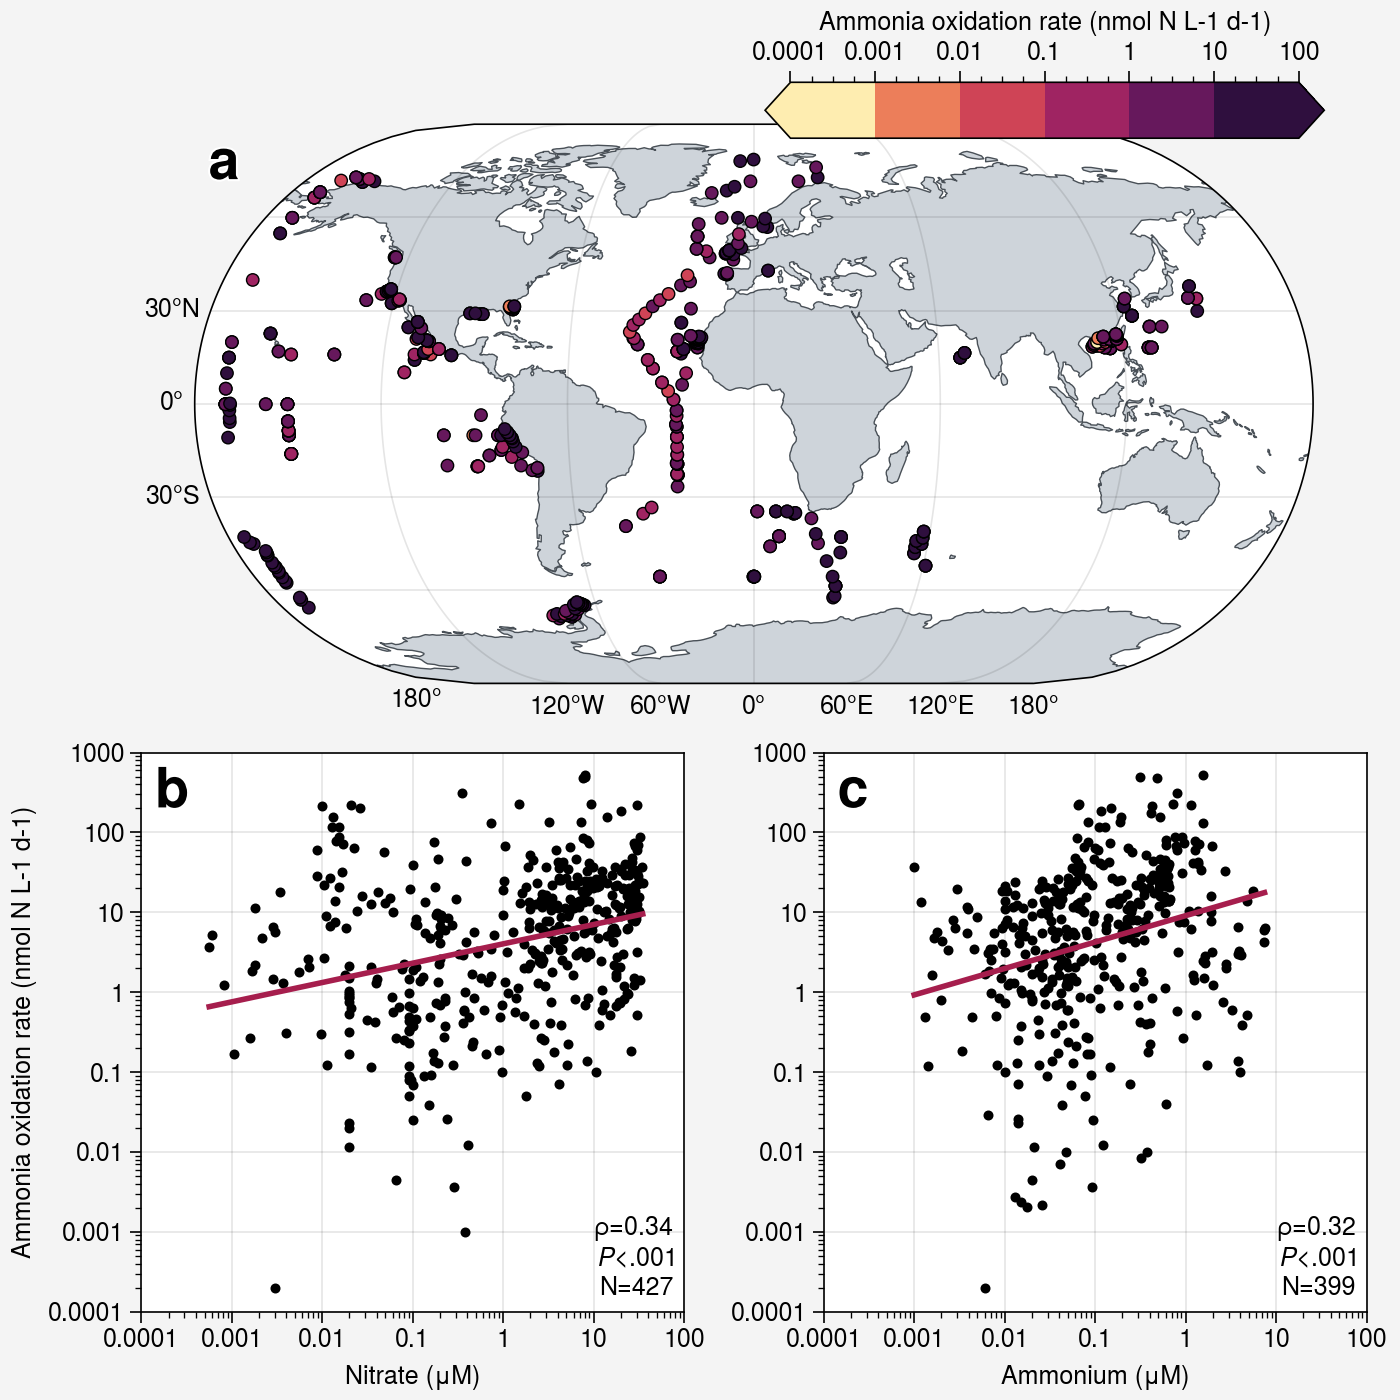

In [29]:
array = [
    [1,1],
    [2,3],
]

fig, axs = plot.subplots(array,proj=('eck3',None),
                         figsize=(7,7),share=False)

ax = axs[0]
ax.format(land=True, landcolor='gray4',landzorder=0,
          coast=True, coastcolor='gray7',coastlinewidth=0.5,coastzorder=1,
          latlabels=True, lonlabels=True)

plot_data = plot_data_only_ammOx
plot_x = plot_data['lon']
plot_y = plot_data['lat']
plot_c = plot_data['ammOxRate_median']
m = ax.scatter(plot_x,plot_y,
              c=plot_c,cmap='matter',
              levels=[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2],
              robust=True,
              s=20,mec='k',mew=0.5,
              zorder=2)
axins1 = inset_axes(
    ax,
    width="50%",
    height="10%",
    loc="upper right",
    bbox_to_anchor=(0.01,0.075,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             label='Ammonia oxidation rate (nmol N L-1 d-1)',
             extend='both',
             )
axins1.xaxis.set_ticks_position('top')
axins1.xaxis.set_label_position('top')
axins1.xaxis.set_ticklabels(['0.0001','0.001','0.01','0.1','1','10','100'])

plot_data_list = [plot_data_ammOx_no3,plot_data_ammOx_nh4]
plot_x_list = ['NO3_median','NH4_median']
plot_y_list = ['ammOxRate_median','ammOxRate_median']
for i, (plot_data,plot_x,plot_y) in enumerate(zip(plot_data_list,plot_x_list,plot_y_list)):
    
    ax = axs[1,i]
    ax.scatter(plot_data[plot_x],plot_data[plot_y],m='.',c='k')

    ### calculate log10 for plot_x and plot_y
    plot_data['Log10_'+plot_x] = np.log10(plot_data[plot_x])
    plot_data['Log10_'+plot_y] = np.log10(plot_data[plot_y])
    plot_data[['Log10_'+plot_x,'Log10_'+plot_y]] = plot_data[['Log10_'+plot_x,'Log10_'+plot_y]
                                                             ].replace([np.inf,-np.inf],np.nan)
    plot_data = plot_data.dropna(subset=['Log10_'+plot_x,'Log10_'+plot_y]).reset_index(drop=True)
    
    # ### orthoganal distance regression
    # X = plot_data['Log10_'+plot_x]
    # y = plot_data['Log10_'+plot_y]
    # odr_dat = scipy.odr.Data(X,y)
    # linear_func = lambda beta,x: beta[0]*x + beta[1]
    # odr_func = scipy.odr.Model(linear_func)
    # odr = scipy.odr.ODR(odr_dat,odr_func,beta0=[1.,0.])
    # out = odr.run()
    # slope = out.beta[0]
    # intercept = out.beta[1]
    # X_pred = np.linspace(X.min(),X.max(),100)
    # y_pred = linear_func(out.beta,X_pred)
    # ax.plot(10**X_pred,10**y_pred,c='k',ls='--',lw=2,label='ODR fit')

    # ### calculate score and pval for odr fit
    # # degree of freedom = len(plot_data)-2
    # degFree = len(plot_data)-2
    # beta_0 = 0
    # t_stat = out.beta[0]-beta_0/out.sd_beta[0]
    # pval = stats.t.sf(abs(t_stat),degFree)*2
    # print(pval)
    # pval_label = label_pvalues(pval)

    # ax.text(0.98,0.02,
    #         f't={t_stat:.2f}\n{pval_label}\nN={len(plot_data)}',
    #         transform=ax.transAxes,
    #         ha='right',va='bottom')
            
    ### ols fit
    ols = LinearRegression()
    X = plot_data['Log10_'+plot_x].values.reshape(-1,1)
    y = plot_data['Log10_'+plot_y]
    ols.fit(X,y)
    slope = ols.coef_[0]
    intercept = ols.intercept_
    X_pred = np.linspace(X.min(),X.max(),100)
    y_pred = ols.predict(X_pred.reshape(-1,1))
    ax.plot(10**X_pred,10**y_pred,c='pink9',lw=2,label='Linear fit')
    ### rho and p-value
    rho,pval = scipy.stats.spearmanr(X,y)
    pval_label = label_pvalues(pval)
    ax.text(0.98,0.02,
            f'$\\rho$={rho:.2f}\n{pval_label}\nN={len(plot_data)}',
            transform=ax.transAxes,
            ha='right',va='bottom')

axs[1,0].format(
    ylabel='Ammonia oxidation rate (nmol N L-1 d-1)',
    xlabel='Nitrate (μM)',
    xscale='log',
    yscale='log',
    xlim=(1e-4,1e2),
    ylim=(1e-4,1e3),
)

axs[1,0].format(
    ylabel='Ammonia oxidation rate (nmol N L-1 d-1)',
    xlabel='Nitrate (μM)',
    xscale='log',
    yscale='log',
    xlim=(1e-4,1e2),
    ylim=(1e-4,1e3),
)

axs[1,1].format(
    ylabel='',
    xlabel='Ammonium (μM)',
    xscale='log',
    yscale='log',
    xlim=(1e-4,1e2),
    ylim=(1e-4,1e3),
)
    
axs.format(
    abc=True,abcloc='ul',abcstyle='a',
    rc_kw={'abc.size':20},
)

fpath = fr'{local_github_path}/figures/'
fname = 'gridded_AOR_nitrate_ammonium.pdf'
fig.savefig(os.path.join(fpath,fname),dpi=300,bb_inches='tight')

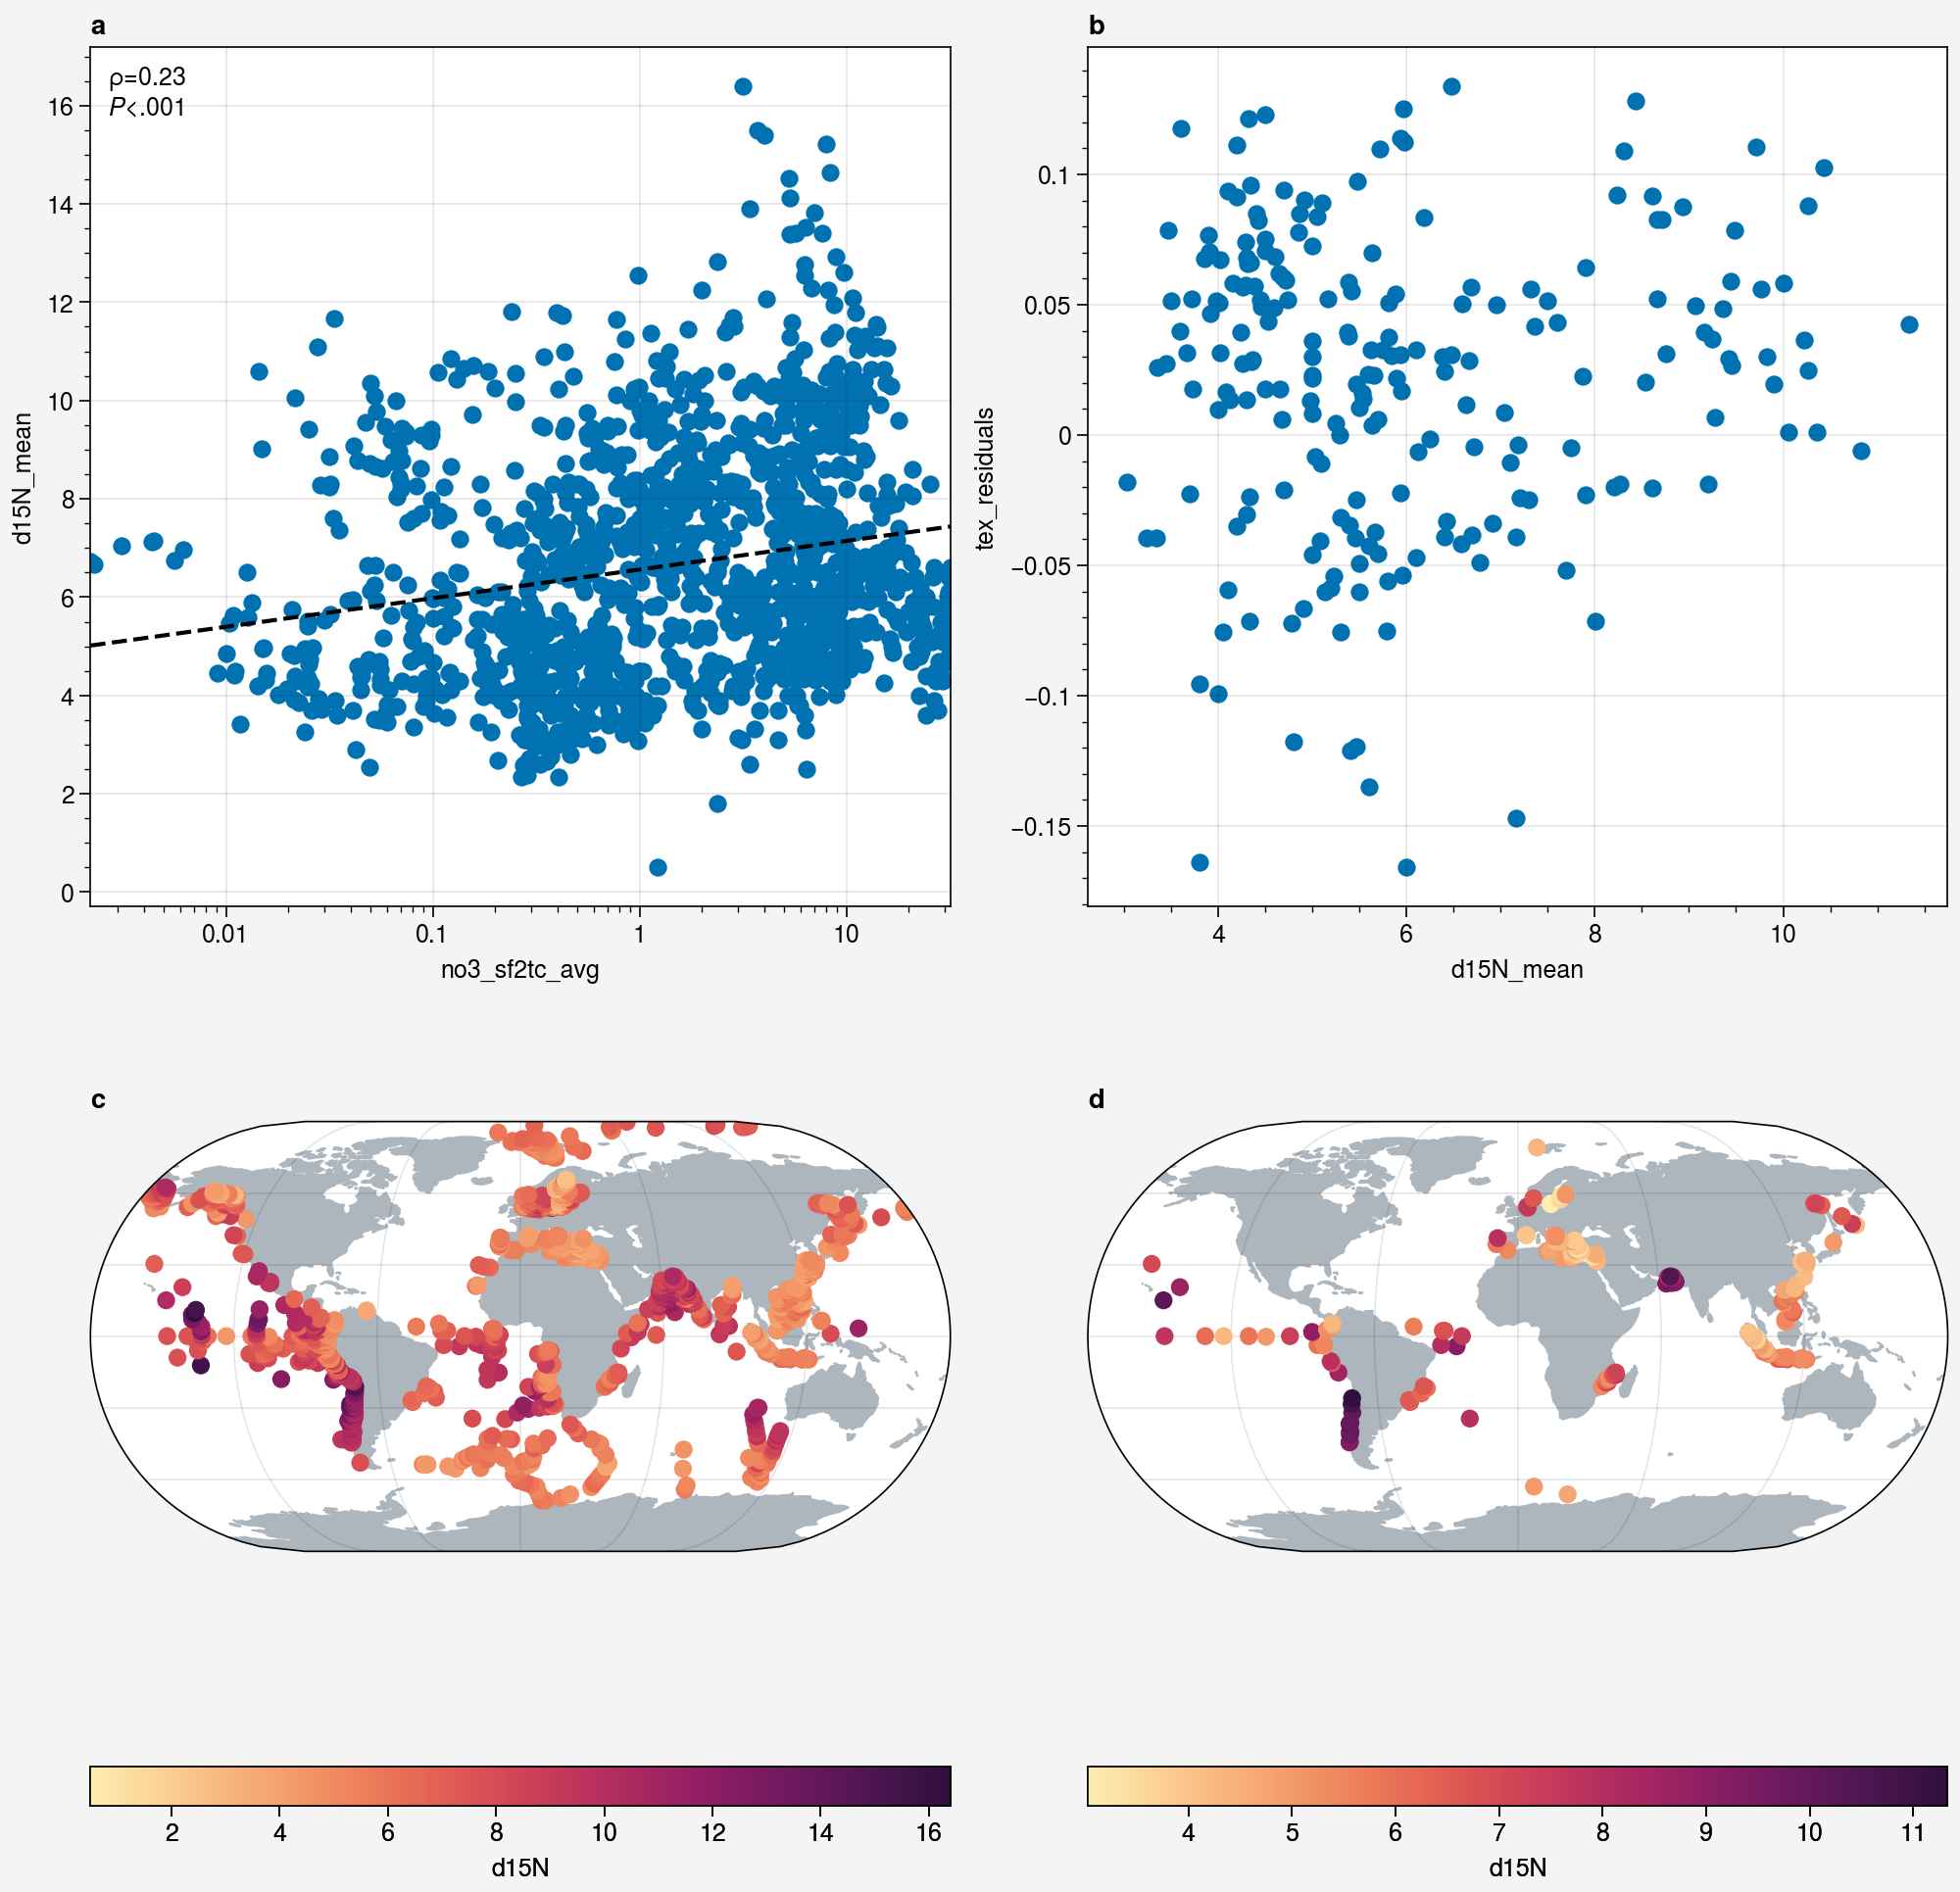

In [30]:
fig, axs = plot.subplots(ncols=2,
                         share=0,
                         nrows=2,
                         proj=(None,None,
                               'eck3','eck3'),
                         width=10)

### scatter plot between d15N and thermocline-integrated nitrate at same grid

nonnan_idx = (coretop_gridded_d15N_ds['d15N_count']>0) & (thermocline_nitrate_da.notnull())
d15N_values = coretop_gridded_d15N_ds.where(nonnan_idx).to_dataframe().reset_index().dropna()['d15N_mean'].reset_index(drop=True)
nitrate_values = thermocline_nitrate_da.where(nonnan_idx).to_dataframe().reset_index().dropna()['no3_sf2tc_avg'].reset_index(drop=True)
ax = axs[0,0]
ax.scatter(nitrate_values,d15N_values)

### ols regression between d15N and log10(thermocline-integrated nitrate at same grid)
ols = LinearRegression()
log10_nitrate_values = np.log10(nitrate_values)
nonnan_log10_idx = log10_nitrate_values.notnull()
X = log10_nitrate_values[nonnan_log10_idx].values.reshape(-1,1)
y = d15N_values[nonnan_log10_idx].values
ols.fit(X,y)
XX_sample = np.linspace(np.min(X),np.max(X),100).reshape(-1,1)
yy_sample = ols.predict(XX_sample)
ax.plot(10**XX_sample,yy_sample,color='k',linestyle='--',label=f'$R^2$={ols.score(X,y):.2f}')


### spearman correlation and p-value
spearman_corr, spearman_pval = spearmanr(nitrate_values,d15N_values)
ax.text(0.02,0.98,f'$\\rho$={spearman_corr:.2f}\n{label_pvalues(spearman_pval)}',
        transform=ax.transAxes,ha='left',va='top')

ax.format(
    xscale='log',
)

ax = axs[1,0]
ax.format(
    land=True,landcolor='gray5',landzorder=0,
    coast=True,coastcolor='gray5',coastzorder=1,
)
## plot locations of grids with d15N and nitrate values
plot_data = coretop_gridded_d15N_ds.to_dataframe().reset_index().dropna(subset=['d15N_mean']).reset_index(drop=True)
plot_lat = plot_data['lat']
plot_lon = plot_data['lon']
plot_c = plot_data['d15N_mean']
m = ax.scatter(plot_lon,plot_lat,
               c=plot_c,cmap='matter',
               zorder=2)
ax.colorbar(m,label='d15N',loc='b')



### scatter plot between d15N and tex_residuals
nonnan_idx = (coretop_gridded_d15N_ds['d15N_count']>0) & (gridded_coretop_ds['tex_residuals'].notnull())
d15N_values = coretop_gridded_d15N_ds.where(nonnan_idx).to_dataframe().reset_index().dropna()['d15N_mean'].reset_index(drop=True)
tex_residual_values = gridded_coretop_ds['tex_residuals'].where(nonnan_idx).to_dataframe().reset_index().dropna()['tex_residuals'].reset_index(drop=True)
count_values = coretop_gridded_d15N_ds.where(nonnan_idx).to_dataframe().reset_index().dropna()['d15N_count'].reset_index(drop=True)

ax = axs[0,1]
ax.scatter(d15N_values,tex_residual_values)

ax = axs[1,1]
ax.format(
    land=True,landcolor='gray5',landzorder=0,
    coast=True,coastcolor='gray5',coastzorder=1,
)
### plot_lat and plot_lon of grids with d15N and tex_residuals values
plot_data = coretop_gridded_d15N_ds.where(nonnan_idx).to_dataframe().reset_index().dropna(subset=['d15N_mean']).reset_index(drop=True)    
plot_lat = plot_data['lat']
plot_lon = plot_data['lon']
plot_c = plot_data['d15N_mean']
m = ax.scatter(plot_lon,plot_lat,
           c=plot_c,cmap='matter',
           zorder=2)
ax.colorbar(m,label='d15N',loc='b')

## Fig. 2: Coretop TEX residuals

best_window_size = 19


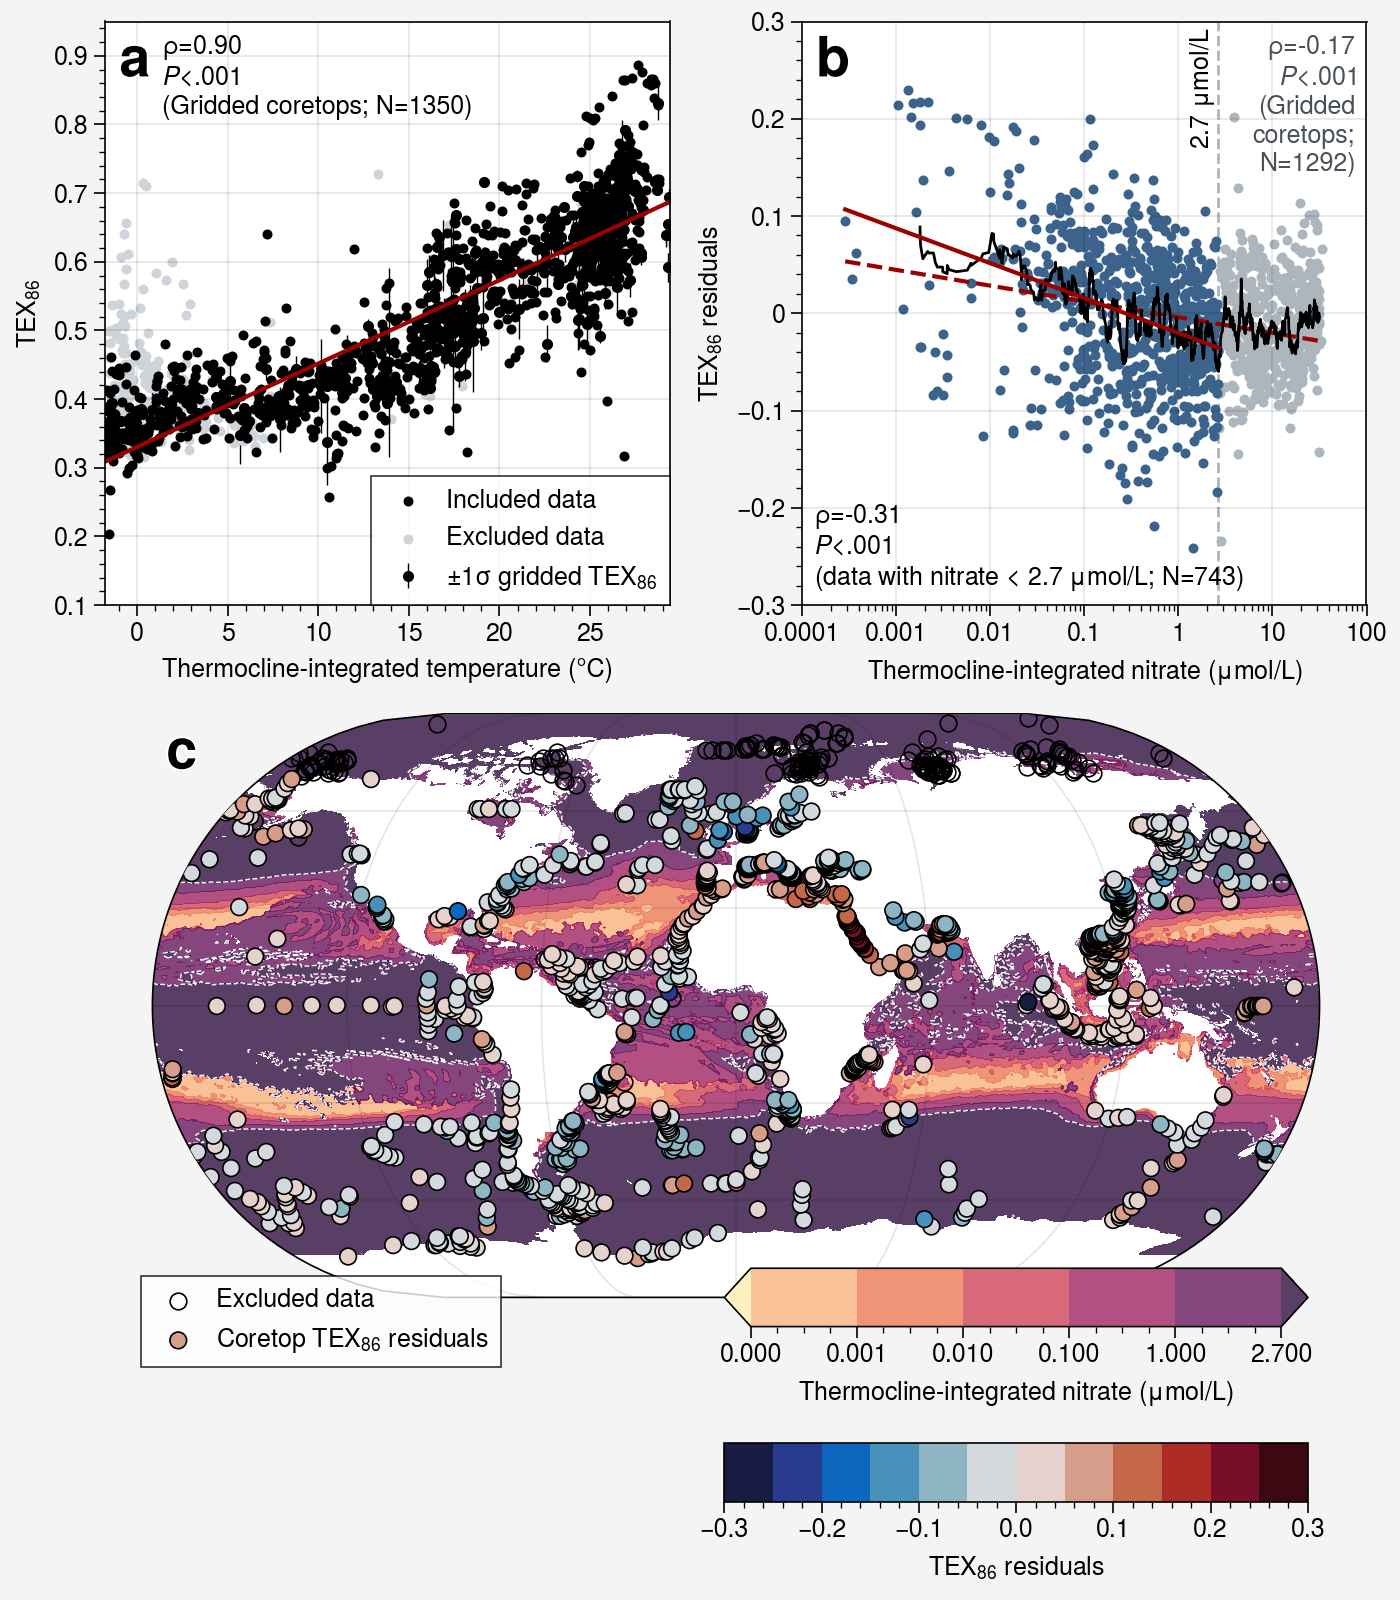

In [31]:
def running_mean_log10(x, y, window_size):
        # Convert x to log10 scale
        log_x = np.log10(x)
        
        # Create a DataFrame with log_x and y
        df = pd.DataFrame({'log_x': log_x, 'y': y})
        
        # Sort the DataFrame by log_x
        df = df.sort_values(by='log_x')
        
        # Calculate the running mean of y with the specified window size
        df['y_running_mean'] = df['y'].rolling(window=window_size, center=True).mean()
        
        return df['log_x'], df['y_running_mean']


plot_coretop = xr.merge([gridded_coretop_ds,t_sf2tc_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','t_sf2tc_avg']).reset_index(drop=True)
plot_coretop_no3 = xr.merge([gridded_coretop_ds,thermocline_nitrate_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','no3_sf2tc_avg']).reset_index(drop=True)

exclude_coretop = coretop_df[coretop_df['QC_flag']=='exclude']
array = [
    [1,2],
    [3,3]
]
projs = (None,None,'eck3')
fig, axs = plot.subplots(array,proj=projs,
                         figsize=(7,8),
                         share=False,\
                         )



ax = axs[0]
ax.format(
    xlabel='Thermocline-integrated temperature (\N{DEGREE SIGN}C)',
    ylabel='TEX$_{86}$'
)
plot_data = plot_coretop[plot_coretop['lat']<70][['t_sf2tc_avg',
                                                  'tex_median']].dropna().reset_index(drop=True)
plot_x = plot_data['t_sf2tc_avg']
plot_y = plot_data['tex_median']
ax.scatter(plot_x,plot_y,
           m='.',c='k',zorder=2,label='Included data')

plot_err_data = plot_coretop[plot_coretop['lat']<70][['t_sf2tc_avg',
                                                    'tex_median','tex_std']].dropna().reset_index(drop=True)
plot_x_err_data = plot_err_data['t_sf2tc_avg']
plot_y_err_data = plot_err_data['tex_median']
plot_yerr = plot_err_data['tex_std']
ax.errorbar(plot_x_err_data.values,plot_y_err_data.values,
            yerr=plot_yerr.values,
            lw=0.5,
            fmt='.',
            c='k',
            zorder=1,
            capsize=0,
            label='$\\pm$1$\sigma$ gridded TEX$_{86}$')

plot_data = plot_coretop[plot_coretop['lat']>70][['t_sf2tc_avg','tex_median']].dropna()
plot_x = plot_data['t_sf2tc_avg']
plot_y = plot_data['tex_median']
ax.scatter(plot_x,plot_y,
           m='.',c='gray4',zorder=1,
           label='Excluded data')

plot_x = exclude_coretop['thermocline_T_depthIntegral']
plot_y = exclude_coretop['TEX86']
ax.scatter(plot_x,plot_y,m='.',c='gray4',zorder=0,label='')

reg_data = plot_coretop[plot_coretop['lat']<70][['t_sf2tc_avg','tex_median']].dropna()
reg_data2 = reg_data[['t_sf2tc_avg','tex_median']].dropna()
ols_tex_thermoT_thisStudy = LinearRegression()
XX = reg_data2['t_sf2tc_avg']
yy = reg_data2['tex_median']
ols_tex_thermoT_thisStudy.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols_tex_thermoT_thisStudy.predict(XX_sample.reshape(-1,1))
ax.plot(XX_sample,yy_pred,c='deep red')
rho, pval = spearmanr(reg_data2['t_sf2tc_avg'],reg_data2['tex_median'])
pval_label = label_pvalues(pval)
ax.text(0.10,0.98,f'$\\rho$={rho:.2f}\n{pval_label}\n(Gridded coretops; N={len(reg_data2)})',
        transform=ax.transAxes,
        ha='left',va='top')

h, l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='lr',ncols=1)
ax.format(
        ylim=(0.1,0.95),
)
#########################################################################################
ax = axs[1]

plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70][['no3_sf2tc_avg','tex_residuals']].dropna()
reg_data = plot_data
reg_data['log_thermocl_depthIntg_nitrate'] = np.log10(reg_data['no3_sf2tc_avg'])
reg_data['log_thermocl_depthIntg_nitrate'] = reg_data['log_thermocl_depthIntg_nitrate'].replace([-np.inf,np.inf],np.nan)
ols = LinearRegression()
XX = reg_data['log_thermocl_depthIntg_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
ax.plot(10**XX_sample,yy_pred,c='deep red',ls='--')
rho, pval = spearmanr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
ax.text(0.98,0.98,f'$\\rho$={rho:.2f}\n{pval_label}\n(Gridded\ncoretops;\nN={len(reg_data)})',
        transform=ax.transAxes,
        ha='right',va='top',
        c='gray7')

sel_x_param = 'no3_sf2tc_avg'
sel_y_param = 'tex_residuals'
### linear fit between log(nitrate) and TEX residuals
pre_reg_data = plot_data
pre_reg_data = pre_reg_data.sort_values(by=sel_x_param).reset_index(drop=True)

### determine best window size
window_size = np.arange(5,100,1)
score_list = []
for sel_window_size in window_size:
        log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],sel_window_size)
        lowno3_threshold_tmp = 10**log_x[y_running_mean.idxmin()]
        reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold_tmp]
        rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
        score_list.append(rho)
best_window_size = window_size[np.argmin(score_list)]
# best_window_size = 100
print(f'best_window_size = {best_window_size}')
### find x value with minimum running mean of y
log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],best_window_size)
ax.axvline(10**log_x[y_running_mean.idxmin()],color='gray5',ls='--',lw=1,zorder=0)
lowno3_threshold = np.round(10**log_x[y_running_mean.idxmin()],decimals=1)
ax.text(lowno3_threshold-0.1,0.99,f'{lowno3_threshold:.1f} $\mu$mol/L',transform=ax.get_xaxis_transform(),
        ha='right',va='top',
        rotation=90)
ax.plot(10**log_x,y_running_mean,c='k',lw=1)

plot_x = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_x_param]
plot_y = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_y_param]
ax.scatter(plot_x,plot_y,marker='.',color='denim',label='Coretops')


plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70][[sel_x_param,sel_y_param]].dropna()
plot_x_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_x_param]
plot_y_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_y_param]
ax.scatter(plot_x_exclude,plot_y_exclude,
            marker='.',color='gray5',
            label='Excluded data',zorder=0)

reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold]

reg_data['log_'+sel_x_param] = np.log10(reg_data[sel_x_param])
reg_data['log_'+sel_x_param] = reg_data['log_'+sel_x_param].replace([-np.inf,np.inf],np.nan)
reg_data = reg_data.dropna(how='any',subset=[sel_x_param,sel_y_param,'log_'+sel_x_param])
ols = sm.OLS(reg_data[sel_y_param],sm.add_constant(reg_data['log_'+sel_x_param])).fit()
plot_x_fit = np.linspace(reg_data['log_'+sel_x_param].min(),reg_data['log_'+sel_x_param].max(),100)
plot_y_fit = ols.predict(sm.add_constant(plot_x_fit))
ax.plot(10**plot_x_fit,plot_y_fit,c='deep red',
        label='TEX residuals')

rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
pval_label = label_pvalues(pval)
ax.text(0.02,0.02,f'$\\rho$={rho:.2f}\n{pval_label}\n(data with nitrate < {lowno3_threshold:.1f} $\mu$mol/L; N={len(reg_data)})',
        transform=ax.transAxes,
        ha='left',va='bottom')


ax.format(
    xscale='log',
    xlim=(1e-4,1e2),
    ylim=(-0.3,0.3),
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals'
)
#########################################################################################
ax = axs[2]

# ax.format(land=True, landcolor='gray4',landzorder=0,
#         latlabels='lr', lonlabels='top',
#         gridcolor='w',gridlinewidth=1,
#         latlocator=[-60,-30,0,30,60],
#         coast=True, coastcolor='gray7',
#         coastlinewidth=0.5,
#         coastzorder=1,)
###### plot a contour line of thermocline-integrated nitrate at lowno3_threshold μM
m = thermocline_nitrate_da.plot.contourf(ax=ax,levels=[1e-4,1e-3,1e-2,1e-1,1,lowno3_threshold],
                                        cmap='matter',alpha=0.8,
                                        add_colorbar=False,robust=True,
                                        label=None,rasterized=True)

axins1 = inset_axes(
    ax,
    width="50%",
    height="10%",
    loc="lower right",
    bbox_to_anchor=(-0.01,-0.05,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)

axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             label='Thermocline-integrated nitrate ($\mu$mol/L)',
             )


thermocline_nitrate_da.plot.contour(ax=ax,levels=[0,lowno3_threshold],
                                                 linewidths=0.5,
                                                 linestyles='dashed',
                                                 colors='w',robust=True)

ax.set_title('')
###### plot tex residuals on map

plot_x = exclude_coretop['Longitude']
plot_y = exclude_coretop['Latitude']
ax.scatter(plot_x,plot_y,m='o',mec='k',facecolor='none',zorder=2)

plot_data = plot_coretop[plot_coretop['lat']>70][['lon','lat','tex_median']].dropna(subset=['tex_median'])
plot_x = plot_data['lon']
plot_y = plot_data['lat']
ax.scatter(plot_x,plot_y,
           m='o',mec='k',facecolor='none',zorder=2,
           label='Excluded data')

plot_data = plot_coretop[plot_coretop['lat']<70][['lon','lat','tex_residuals']].dropna()
plot_x = plot_data['lon']
plot_y = plot_data['lat']
plot_c = plot_data['tex_residuals']
m=ax.scatter(plot_x,plot_y,
           c=plot_c,mec='k',
           levels=np.arange(-0.3,0.31,0.05),
           transform=ccrs.PlateCarree(),
           m='o',cmap='Balance',
           label='Coretop TEX$_{86}$ residuals',
           zorder=3)

h,l = ax.get_legend_handles_labels()

ax.legend(h[1:],l[1:],loc='lower left',
          bbox_to_anchor=(-0.01,-0.12,1,1),
          ncols=1)

axins1 = inset_axes(
    ax,
    width="50%",
    height="10%",
    loc="lower right",
    bbox_to_anchor=(-0.01,-0.35,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             label='TEX$_{86}$ residuals'
             )



#########################################################################################
axs.format(abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20},)


fpath = fr'{local_github_path}/figures/'
fname = 'gridded_coretops_regression_nitrate_effect_global.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',dpi=1440)

## Fig. 3: Regional nutrient effects

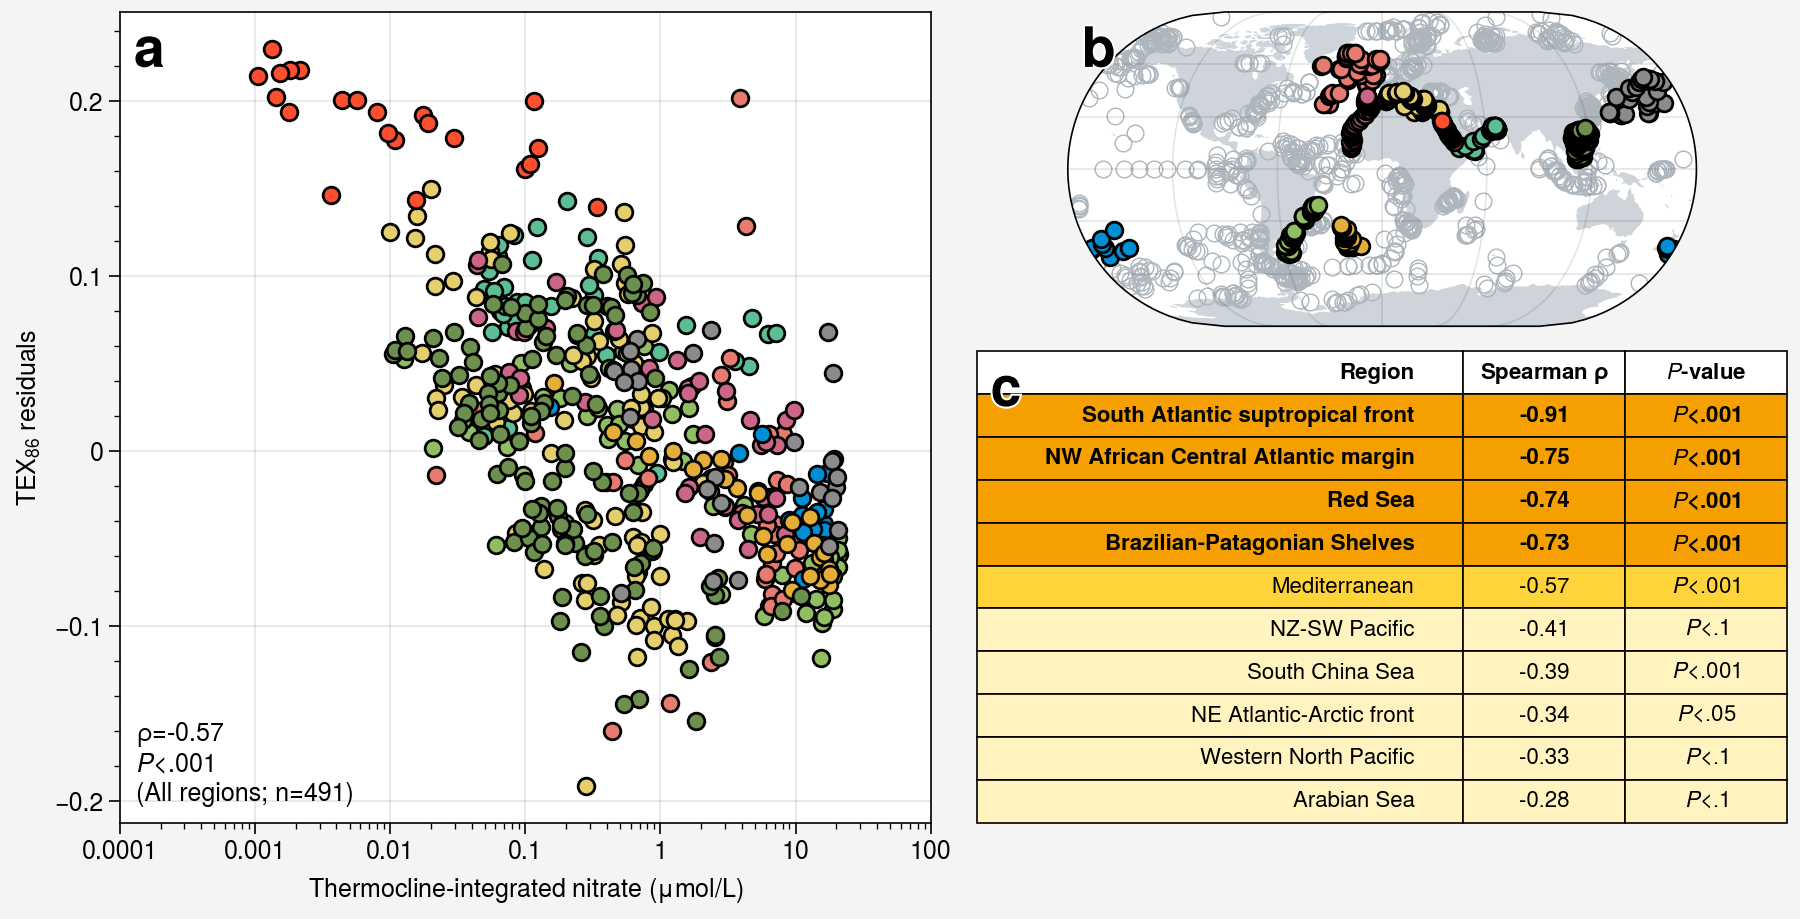

In [32]:
array = [
    [1,1,2,2],
    [1,1,3,3]
]
cyc1 = plot.get_colors('qual1',N=5)
cyc2 = plot.get_colors('538',N=5)

sel_cyc = plot.Cycle(cyc1+cyc2)
### param for plotting
optimal_pval_cutoff = 0.1
nitrate_cutoff = 100

fig, axs = plot.subplots(array,share=0,
                         proj=(None,'eck3',None),
                         hratios=[1,1.5],
                         width=9)

plot_data = xr.merge([gridded_coretop_ds,t_sf2tc_da,thermocline_nitrate_da])
plot_gridded_data = plot_data[['lat','lon','t_sf2tc_avg','no3_sf2tc_avg',
                                        'tex_median','tex_residuals','tex_std','region_ID']].to_dataframe().dropna(subset=['region_ID']).reset_index()
plot_gridded_data['regionName'] = plot_gridded_data['region_ID'].map(regionID_to_regionName_dict)
plot_gridded_data['regionName'] = plot_gridded_data['regionName'].replace({
    'Eastern Indian Ocean (Offshore Indonesia)' : 'Indonesian Offshore',
    'Northern Pacific':'Western North Pacific',
    'Eastern South America Offshore':'Brazilian-Patagonian Shelves',
    'South Atlantic Gyre':'South Atlantic suptropical front',
    'Tropical West African Offshore':'NW African Central Atlantic margin',
    'North Atlantic':'NE Atlantic-Arctic front',
})

plot_gridded_data = plot_gridded_data[plot_gridded_data['no3_sf2tc_avg']<nitrate_cutoff]

ax = axs[1]
ax.format(
    land=True, landcolor='gray4',landzorder=0,
)
grouped = plot_gridded_data.groupby('regionName')

#### calculate rho and pval between tex_residuals and thermocl_depthIntg_nitrate by regions
rho_list = []
pval_list = []
region_name_list = []
for name, group in grouped:
    reg_data = group[['no3_sf2tc_avg','tex_residuals']].dropna()
    if len(reg_data)<10:
        continue
    else:
        rho, pval = spearmanr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
        rho_pearson, pval_pearson = pearsonr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
        region_name_list.append(name)
        rho_list.append(rho)
        pval_list.append(pval)

### build a dataframe to sort by rho
rho_df = pd.DataFrame({'regionName':region_name_list,
                       'rho':rho_list,
                       'pval':pval_list})

sig_regions_ = rho_df[((rho_df['pval']<optimal_pval_cutoff) 
                       & (rho_df['rho']<0))]
                       
sig_regions_ = rho_df[((rho_df['pval']<optimal_pval_cutoff)
                       & (rho_df['rho']<0))][rho_df['regionName'].isin([
                           'Weddell Sea','Arctic Ocean','Drake Passage',
                           'Kara Sea','Greenland Sea',
                           'Laptev Sea',
                           'Sea of Okhotsk',
                        #    'Eastern South America Offshore_far'
                           ])==False]
sig_regions_color_dict = dict(zip(sig_regions_['regionName'],plot.get_colors('tab10',len(sig_regions_))))


for name, group in grouped:
    ### check rho and pval of each region
    if name not in sig_regions_['regionName'].unique():
        ax.scatter(group['lon'],group['lat'],
                    c='none',
                    mec='gray5',mew=0.5,
                    label=name,
                    zorder=1)
    else:
        rho_ = rho_df[rho_df['regionName']==name]['rho'].values[0]
        pval_ = rho_df[rho_df['regionName']==name]['pval'].values[0]
        
        if (pval_<optimal_pval_cutoff 
            and (rho_<0)
            and name!='Weddell Sea'
            and name!='Arctic Ocean'
            and name!='Drake Passage'
            and name!='Kara Sea'
            and name!='Greenland Sea'
            and name!='Laptev Sea'
            and name!='Sea of Okhotsk'
            # and name!='Eastern South America Offshore_far'
            ):
            ax.scatter(group['lon'],group['lat'],
                    cycle=sel_cyc,
                    # c=sig_regions_color_dict.get(name,'gray5'),
                    mec='k',mew=1,
                    label=name,
                    zorder=2)

            

ax = axs[0]
sig_plot_data = plot_gridded_data[plot_gridded_data['regionName'].isin(sig_regions_['regionName'])]
grouped = sig_plot_data.groupby('regionName')   
for name, group in grouped:
    ### plot data
    ax.scatter(group['no3_sf2tc_avg'],group['tex_residuals'],
                cycle=sel_cyc,
                mec='k',mew=1,
                label=name,
                zorder=2)
    
### ols regression of all significant regions
reg_data = sig_plot_data[['no3_sf2tc_avg','tex_residuals']].dropna()
reg_data['Log10_nitrate'] = np.log10(reg_data['no3_sf2tc_avg'])
ols = LinearRegression()
XX = reg_data['Log10_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
# ax.plot(10**XX_sample,yy_pred,c='deep red')
### spearman rho and pval
rho, pval = spearmanr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
ax.text(0.02,0.02,f'$\\rho$={rho:.2f}\n{pval_label}\n(All regions; n={len(reg_data)})',
        transform=ax.transAxes,
        ha='left',va='bottom')

### orthoganal distance regression 
X = reg_data['Log10_nitrate']
y = reg_data['tex_residuals']
covx = np.cov(X)
covy = np.cov(y)
odr_dat = scipy.odr.Data(X,y)
def linear_func(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]
odr_func = scipy.odr.Model(linear_func)
odr = scipy.odr.ODR(odr_dat,odr_func,beta0=[-2.,0.2])
out = odr.run()
slope = out.beta[0]
intercept = out.beta[1]
X_pred = np.linspace(X.min(),X.max(),100)
y_pred = linear_func(out.beta,X_pred)
# ax.plot(10**X_pred,y_pred,c='k',ls='--',lw=2,label='ODR fit')

ax.format(
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals',
    xlim=(1e-4,1e2),
    xscale='log',
)

axs.format(
    abc=True,abcstyle='a',rc_kw={'abc.size':20},abcloc='ul',
)

### plot a table reporting rho and pval of significant regions
table_ax = axs[2]
table_ax.axis('off')
table_data = sig_regions_[['regionName','rho','pval']]

### formatted values to be displayed in the table as 4 significant figures
table_data['rho'] = table_data['rho'].apply(lambda x: f'{x:.2f}')
table_data['pval'] = table_data['pval'].apply(lambda x: f'{x:.4f}')
table_data['pval_labels'] = table_data['pval'].apply(lambda x: label_pvalues(float(x)))
table_data = table_data.rename(columns={'regionName':'Region',
                                        'rho':'Spearman $\\rho$',
                                        'pval_labels':r'$\it{P}$-value'})

table_data2 = table_data[['Region','Spearman $\\rho$',r'$\it{P}$-value']].sort_values(by='Spearman $\\rho$',ascending=False).copy()
### color cell with rho < -0.7
### set header text bold
### set header background color
table = table_ax.table(cellText=table_data2.values,
                colLabels=table_data2.columns,
                loc='top',
                bbox=[0,0,1,1],
                colWidths=[0.6,0.2,0.2],
                cellColours=np.reshape(
                    ['yellow7' if float(rho)<-0.7 
                     else 'yellow4' if float(rho)<-0.5 
                     
                     else 'yellow1' 
                     for rho in table_data2['Spearman $\\rho$']]*3,(3,len(table_data))).T
                )
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Header row
        cell.get_text().set_fontweight('bold')
    if col == 0:
        ### set right alignment for the first column
        cell.get_text().set_ha('right')
    else:
        cell.get_text().set_ha('center')
        if col == 1 and row > 0:
            ### set font weight as bold for row with rho < -0.7
            if float(cell.get_text().get_text())<-0.7:
                table[(row,0)].get_text().set_fontweight('bold')
                table[(row,1)].get_text().set_fontweight('bold')                
                table[(row,2)].get_text().set_fontweight('bold')
    
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.5, 1.5)

fpath = fr'{local_github_path}/figures/'
fname = 'gridded_regional_nitrate_effect_sig_regions.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',dpi=1440)

In [33]:
### round rho to 2 decimal places and pval to 4 decimal places
rho_df['rho_labels'] = rho_df['rho'].apply(lambda x: f'{x:.2f}')
rho_df['pval_labels'] = rho_df['pval'].apply(lambda x: f'{x:.4f}')
rho_df[rho_df['rho']<0].sort_values(by='pval')[['regionName','rho_labels','pval_labels']]

regionName rho_labels pval_labels
7         Brazilian-Patagonian Shelves      -0.73      0.0000
30    South Atlantic suptropical front      -0.91      0.0000
22  NW African Central Atlantic margin      -0.75      0.0000
19                       Mediterranean      -0.57      0.0000
31                     South China Sea      -0.39      0.0000
26                             Red Sea      -0.74      0.0001
10                       Drake Passage      -0.39      0.0111
36                         Weddell Sea      -0.68      0.0153
21            NE Atlantic-Arctic front      -0.34      0.0324
2                         Arctic Ocean      -0.49      0.0664
17                            Kara Sea      -0.33      0.0750
39               Western North Pacific      -0.33      0.0813
1                          Arabian Sea      -0.28      0.0871
23                       NZ-SW Pacific      -0.41      0.0931
13  Eastern South America Offshore_far      -0.39      0.1085
38           Western African Upwelling      -0.30      0.1556
8                     Chilean Offshore      -0.22      0.2557
18                          Laptev Sea      -0.20      0.3163
40                          Yellow Sea      -0.09      0.4904
37             West Equatorial Pacific      -0.09      0.7613
3                           Baltic Sea      -0.04      0.8585
14                       Greenland Sea      -0.03      0.9035
28                      Sea of Okhotsk      -0.01      0.9465

## Fig. 4: Paleo case study - Arabian Sea

In [34]:
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'Seierstad2014_NGRIP_d18O_dataset.xlsx'

### data sheet name is "4) d18O and Ca 50 yrs mean"
### data starts from line 6
### header is in line 4
ngrip_df = pd.read_excel(os.path.join(fpath,fname),sheet_name="3) d18O and Ca 20 yrs mean",skiprows=51)

### grab column names from line 4 in the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name="3) d18O and Ca 20 yrs mean",skiprows=49)
header = header.iloc[0,:].values

### add column names to dataframe
ngrip_df.columns = header
ngrip_df = ngrip_df[ngrip_df['Age']<20000]
ngrip_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1997 entries, 0 to 1996
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            1997 non-null   int64  
 1   NGRIP1 depth   980 non-null    float64
 2   d18O NGRIP1    980 non-null    float64
 3   NGRIP2 depth   1045 non-null   float64
 4   d18O NGRIP2    1045 non-null   float64
 5   [Ca2+] NGRIP2  965 non-null    float64
 6   GRIP depth     1997 non-null   float64
 7   d18O GRIP      1997 non-null   float64
 8   [Ca2+] GRIP    1201 non-null   float64
 9   GISP2 depth    1989 non-null   float64
 10  d18O GISP2     1951 non-null   float64
 11  [Ca2+] GISP2   1989 non-null   float64
 12  MCE            1997 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 218.4 KB


In [35]:
import bayspline as bsl

#### read data from tab file to pandas dataframe; data starts after the last line with */

fpath = fr'{local_github_path}/spreadsheets/published_data/Huguet2006_ArabianSea_paleorecords'
fname = 'SO42-74KL_SST.tab'

with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if line.startswith('*/'):
        break
# header = lines[i+1].split()
data = lines[i+2:]
data = [line.split() for line in data]
df = pd.DataFrame(data,columns=['Age_kaBP','SST_UK37','SST_TEX86'])
SO42_75KL_SST_df = df.apply(pd.to_numeric,errors='ignore')
SO42_75KL_SST_df['uk37'] = 0.033*SO42_75KL_SST_df['SST_UK37']+0.044
SO42_75KL_SST_df['sst'] = bsl.predict_sst(SO42_75KL_SST_df['uk37'], prior_std=10).percentile(50)
SO42_75KL_SST_df

100%|██████████| 500/500 [00:35<00:00, 14.03it/s]


Age_kaBP  SST_UK37  SST_TEX86  uk37   sst
0       0.20     27.30      26.39  0.94 28.49
1       0.40     27.36      27.47  0.95 28.63
2       0.60     27.27      27.13  0.94 28.45
3       0.82     27.36      26.82  0.95 28.57
4       1.03     27.12      27.81  0.94 28.11
..       ...       ...        ...   ...   ...
71     20.29     25.12      25.21  0.87 24.77
72     20.90     24.85      23.93  0.86 24.41
73     21.50     25.09      23.78  0.87 24.74
74     22.11     25.15      25.02  0.87 24.77
75     22.72     25.24      24.59  0.88 24.94

[76 rows x 5 columns]

In [36]:
#### read data from tab file to pandas dataframe; data starts after the last line with */

fpath = fr'{local_github_path}/spreadsheets/published_data/Huguet2006_ArabianSea_paleorecords'
fname = 'NIOP-C2_905_PC_SST.tab'

with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if line.startswith('*/'):
        break
# header = lines[i+1].split()
data = lines[i+2:]
data = [line.split() for line in data]
df = pd.DataFrame(data,columns=['Age_kaBP','SST_UK37','SST_TEX86'])
NIOP905_SST_df = df.apply(pd.to_numeric,errors='ignore')
NIOP905_SST_df ['uk37'] = 0.033*NIOP905_SST_df['SST_UK37']+0.044
NIOP905_SST_df ['sst'] = bsl.predict_sst(NIOP905_SST_df['uk37'], prior_std=10).percentile(50)
NIOP905_SST_df

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:33<00:00, 14.82it/s]


Age_kaBP  SST_UK37  SST_TEX86  uk37   sst
0        0.02     26.30      25.71  0.91 26.59
1        0.21     26.33      26.24  0.91 26.70
2        0.40     26.33      25.79  0.91 26.67
3        0.59     26.49      26.09  0.92 26.96
4        0.78     26.42      26.42  0.92 26.85
..        ...       ...        ...   ...   ...
106     21.91     25.09      22.59  0.87 24.71
107     22.16     25.49      22.47  0.89 25.29
108     22.42     25.39        NaN  0.88 25.15
109     22.68     25.77        NaN  0.89 25.72
110     22.94     25.52        NaN  0.89 25.36

[111 rows x 5 columns]

In [37]:
slope = ols_tex_thermoT_thisStudy.coef_[0]
intercept = ols_tex_thermoT_thisStudy.intercept_

fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'PhanSST_v001.csv'
PhanSST_df = pd.read_csv(os.path.join(fpath,fname))
PhanTEX_df = PhanSST_df[PhanSST_df['ProxyType']=='tex'].reset_index(drop=True)

NIOP905_tex_df = PhanSST_df[PhanSST_df['SiteName']=='NIOP-C2_905_PC'].reset_index(drop=True)
NIOP905_tex_df['SST'] = (NIOP905_tex_df['ProxyValue'] - intercept)/slope

SO42_75KL_tex_df = PhanSST_df[PhanSST_df['SiteName']=='SO42-74KL'].reset_index(drop=True)
SO42_75KL_tex_df['SST'] = (SO42_75KL_tex_df['ProxyValue'] - intercept)/slope

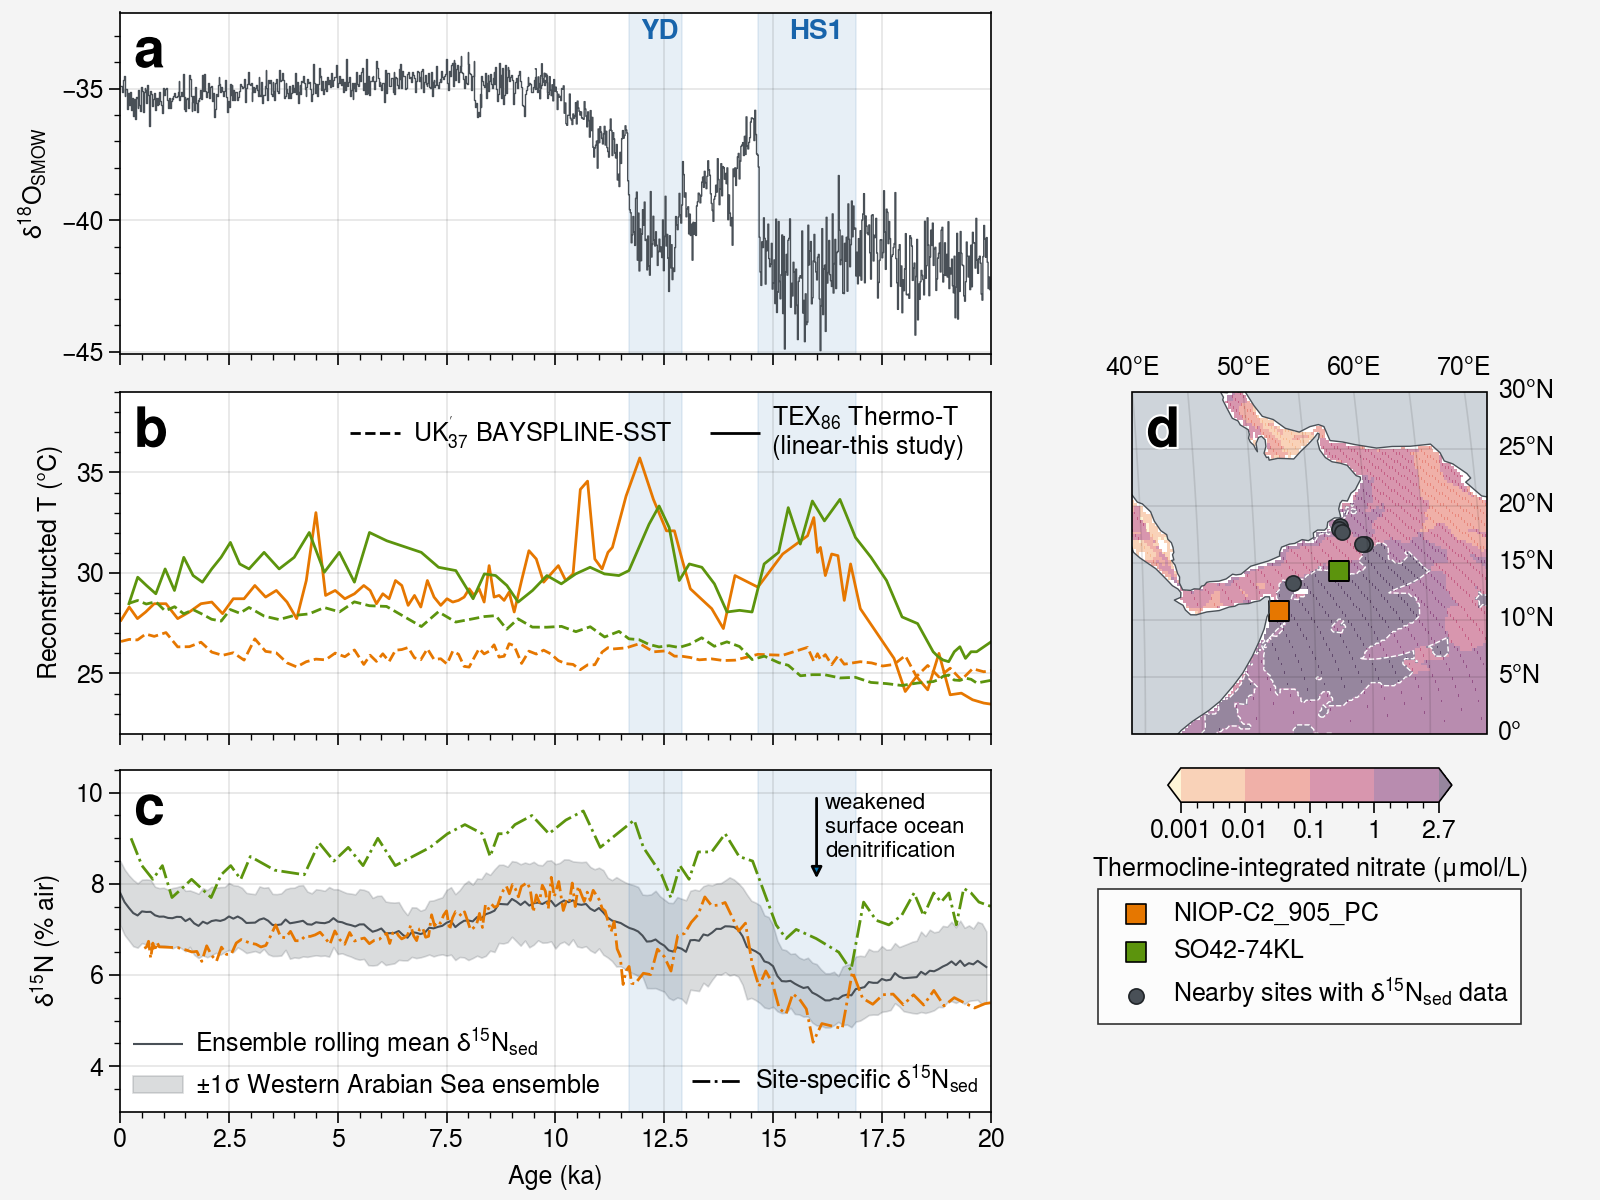

In [38]:
array = [
    [1,1,1,0,0],
    [2,2,2,4,4],
    [3,3,3,0,0],
]
fig, axs = plot.subplots(
    array,
    figsize=(8,6),
    sharey=0,
    proj=(None,None,None,'eck3')
    )


########## site locations
ax = axs[3]
ax.format(land=True,landcolor='gray4',landzorder=0,
          coast=True,coastcolor='gray7',coastlinewidth=0.5,
          latlim=(0,30),lonlim=(40,70),
          latlabels='r',lonlabels='t',)


### lat lon for NIOP-C2_905_PC = 10.767N,51.95E
### lat lon for SO42-74KL = 14.321N, 57.347E
ax.scatter(51.95,10.767,c='yellow9',
           mec='k',marker='s',s=50,
           label='NIOP-C2_905_PC',
           zorder=2)
ax.scatter(57.347,14.321,c='lime9',
           mec='k',marker='s',s=50,
           label='SO42-74KL',
           zorder=2)


### plot thermocline-integrated nitrate on the map
m=thermocline_nitrate_da.sel(lat=slice(-10,30),lon=slice(25,90)).plot(ax=ax,
                                                                    zorder=0,
                                                                    levels=[1e-3,1e-2,1e-1,1,lowno3_threshold],
                                                                    cmap='matter',
                                                                    add_colorbar=False,
                                                                    alpha=0.5,
                                                                    rasterized=True)
ax.set_title('')
### plot the lowno3_threshold μM contour line
thermocline_nitrate_da.sel(lat=slice(-10,30),lon=slice(25,90)
                                       ).plot.contour(ax=ax,levels=[0,lowno3_threshold],
                                                        zorder=1,
                                                        linewidths=0.5,
                                                        linestyles='dashed',
                                                        colors='w',robust=True)

axins1 = inset_axes(
    ax,
    width="80%",
    height="10%",
    loc="lower center",
    bbox_to_anchor=(0,-0.2,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             label='Thermocline-integrated nitrate ($\mu$mol/L)',
             extend='both'
             )
axins1.xaxis.set_ticklabels(['0.001','0.01','0.1','1',f'{lowno3_threshold}'])

###### time series plot
ax = axs[0]
ax.format(
    ylabel='$\delta^{18}$O$_{SMOW}$',
)
plot_data = ngrip_df.dropna(how='all',subset=['d18O NGRIP1']).reset_index(drop=True)
plot_x = plot_data['Age']/1000
plot_y = plot_data['d18O NGRIP1']
ax.plot(plot_x,plot_y,c='gray7',lw=0.5,label='NGRIP')

plot_data = ngrip_df.dropna(how='all',subset=['d18O NGRIP2']).reset_index(drop=True)
plot_x = plot_data['Age']/1000
plot_y = plot_data['d18O NGRIP2']
ax.plot(plot_x,plot_y,c='gray7',lw=0.5,label='')


ax = axs[1]
ax.format(
    ylabel='Reconstructed T ($\degree$C)',
)
plot_data = NIOP905_SST_df
plot_x = plot_data['Age_kaBP']
plot_y = plot_data['sst']
ax.plot(plot_x,plot_y,c='yellow9',ls='--',lw=1)

plot_data = NIOP905_tex_df
plot_x = plot_data['Age']*1000
plot_y2 = plot_data['SST']
ax.plot(plot_x,plot_y2,c='yellow9',lw=1)

plot_data = SO42_75KL_SST_df 
plot_x = plot_data['Age_kaBP']
plot_y = plot_data['sst']
ax.plot(plot_x,plot_y,c='lime9',ls='--',lw=1)

plot_data = SO42_75KL_tex_df
plot_x = plot_data['Age']*1000
plot_y2 = plot_data['SST']
ax.plot(plot_x,plot_y2,c='lime9',lw=1)

#### plotting d15N data


ax = axs[2]
ax.format(
    ylabel='$\delta^{15}$N (% air)',
    ylim=(3,10.5)
)
    
#### add an arrow with annotation showing reduced denitrification during YD and HS1
ax.annotate('',
            xy=(16,10),xytext=(16,8),
            arrowprops=dict(arrowstyle='<|-',lw=1),
            ha='center',va='center',fontsize=8)
ax.text(16.2,10,'weakened\nsurface ocean\ndenitrification',
        ha='left',va='top',fontsize=8)

plot_data = downcore_d15N_df[downcore_d15N_df['Latitude'].between(0,30)
                             & downcore_d15N_df['Longitude'].between(40,60)].dropna(subset=['Age','d15N'])
plot_data = plot_data[plot_data['Age']<20]

### plot rolling mean of d15N data 
rolling_age_widow = 0.5
age_range = np.arange(0,20,0.1)
rolling_mean = pd.DataFrame()
rolling_mean['Age'] = age_range
rolling_mean['d15N'] = np.nan
rolling_mean['d15N_std'] = np.nan
rolling_mean['d15N_median'] = np.nan    
for i in range(len(age_range)):
    age = age_range[i]
    rolling_mean['d15N'][i] = plot_data[(plot_data['Age']>=age-rolling_age_widow)
                                        & (plot_data['Age']<=age+rolling_age_widow)]['d15N'].mean()
    rolling_mean['d15N_std'][i] = plot_data[(plot_data['Age']>=age-rolling_age_widow)
                                                & (plot_data['Age']<=age+rolling_age_widow)]['d15N'].std()
    rolling_mean['d15N_median'][i] = plot_data[(plot_data['Age']>=age-rolling_age_widow)
                                        & (plot_data['Age']<=age+rolling_age_widow)]['d15N'].median()
plot_x = rolling_mean['Age']
plot_y = rolling_mean['d15N']
ax.plot(plot_x,plot_y,c='gray7',lw=0.75,label='Ensemble rolling mean $\delta^{15}$N$_{sed}$')
ax.fill_between(plot_x,plot_y-rolling_mean['d15N_std'],plot_y+rolling_mean['d15N_std'],
                color='gray7',alpha=0.2,label='$\pm$1$\sigma$ Western Arabian Sea ensemble')

sel_sites = ['NIOP 905','SO42-74KL']
sel_colors = ['yellow9','lime9']
plot_data = downcore_d15N_df[downcore_d15N_df['core_name'].isin(sel_sites)].dropna(subset=['Age','d15N'])
grouped = plot_data.groupby('core_name')
for name, group in grouped:
    group = group.sort_values(by='Age').reset_index(drop=True)
    plot_x = group['Age']
    plot_y = group['d15N']
    ax.plot(plot_x,plot_y,
            c=sel_colors[sel_sites.index(name)],
            lw=1,ls='-.',label='site-specific $\delta^{15}$N$_{sed}$')

### plot lat lon locations for sites other than NIOP 905 and SO42-74KL
plot_data = downcore_d15N_df[~downcore_d15N_df['core_name'].isin(sel_sites)
                                & downcore_d15N_df['Latitude'].between(0,30)
                                & downcore_d15N_df['Longitude'].between(40,60)].dropna(subset=['Age','d15N'])
grouped = plot_data.groupby('core_name')
for name, group in grouped:
    group = group.sort_values(by='Age').reset_index(drop=True)
    plot_lat = group['Latitude'].unique()
    plot_lon = group['Longitude'].unique()
    axs[-1].scatter(plot_lon,plot_lat,label=name,
            c='gray7',marker='o',mec='gray9',s=30)
    
    # plot_age = group['Age']
    # plot_d15N = group['d15N']
    # axs[2].plot(plot_age,plot_d15N,label=name,
    #             c='gray6',lw=0.5,ls='-.')


#### add shaded area highlighting Younger Dryas (YD; 12.9-11.7 ka) and Heinrich stadial 1 (HS1; 16.9-14.5 ka) for all plots
for ax in axs[:3]:
    ax.axvspan(11.7,12.9,color='blue9',alpha=0.1)
    ax.axvspan(14.65,16.9,color='blue9',alpha=0.1)
### add text labels for YD and HS1 at the top of subplot A
ax = axs[0]
ax.text(0.62,0.98,'YD',transform=ax.transAxes,
        ha='center',va='top',color='blue9',
        fontsize=10,fontweight='bold')
ax.text(0.8,0.98,'HS1',transform=ax.transAxes,
        ha='center',va='top',color='blue9',
        fontsize=10,fontweight='bold')



############################################################

h, l = axs[1].get_legend_handles_labels()
h2, l2 = axs[2].get_legend_handles_labels()
h3,l3 = axs[-1].get_legend_handles_labels()


axs[1].legend(h[:2],loc='ul',c='k',
              frameon=False,bbox_to_anchor=(0.25,0,1,1),
              labels=["UK$^{'}_{37}$ BAYSPLINE-SST",'TEX$_{86}$ Thermo-T\n(linear-this study)'])
# axs[2].legend(h2,l2,loc='b')
axs[2].legend([h2[i] for i in [0,-1]],
              [l2[i] for i in [0,-1]],
              loc='ll',ncols=1,
              frameon=False,
            #   labels=['Bulk sediment $\delta^{15}$N']
              )
axs[2].legend([h2[i] for i in [1]],
              loc='lr',ncols=1,
              c='k',
              frameon=False,
              labels=['Site-specific $\delta^{15}$N$_{sed}$']
              )

axs[-1].legend(h3,loc='lower center',ncol=1,
               bbox_to_anchor=(0,-0.85,1,1),
               labels=['NIOP-C2_905_PC','SO42-74KL',
                       'Nearby sites with $\delta^{15}$N$_{sed}$ data'],)
## set the color for the first two marker elements as black

axs.format(
    abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20},
    xlim=(0,20),
    xlabel='Age (ka)',
)

### set ylims for each plot
axs[0].format(ylim=(-45.1,-32.1),yticks=[-45,-40,-35])
axs[1].set_ylim(22,39)
plt.show()

fpath = fr'{local_github_path}/figures/'
fname = 'paleo_showcase_ArabianSea.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',dpi=1440)

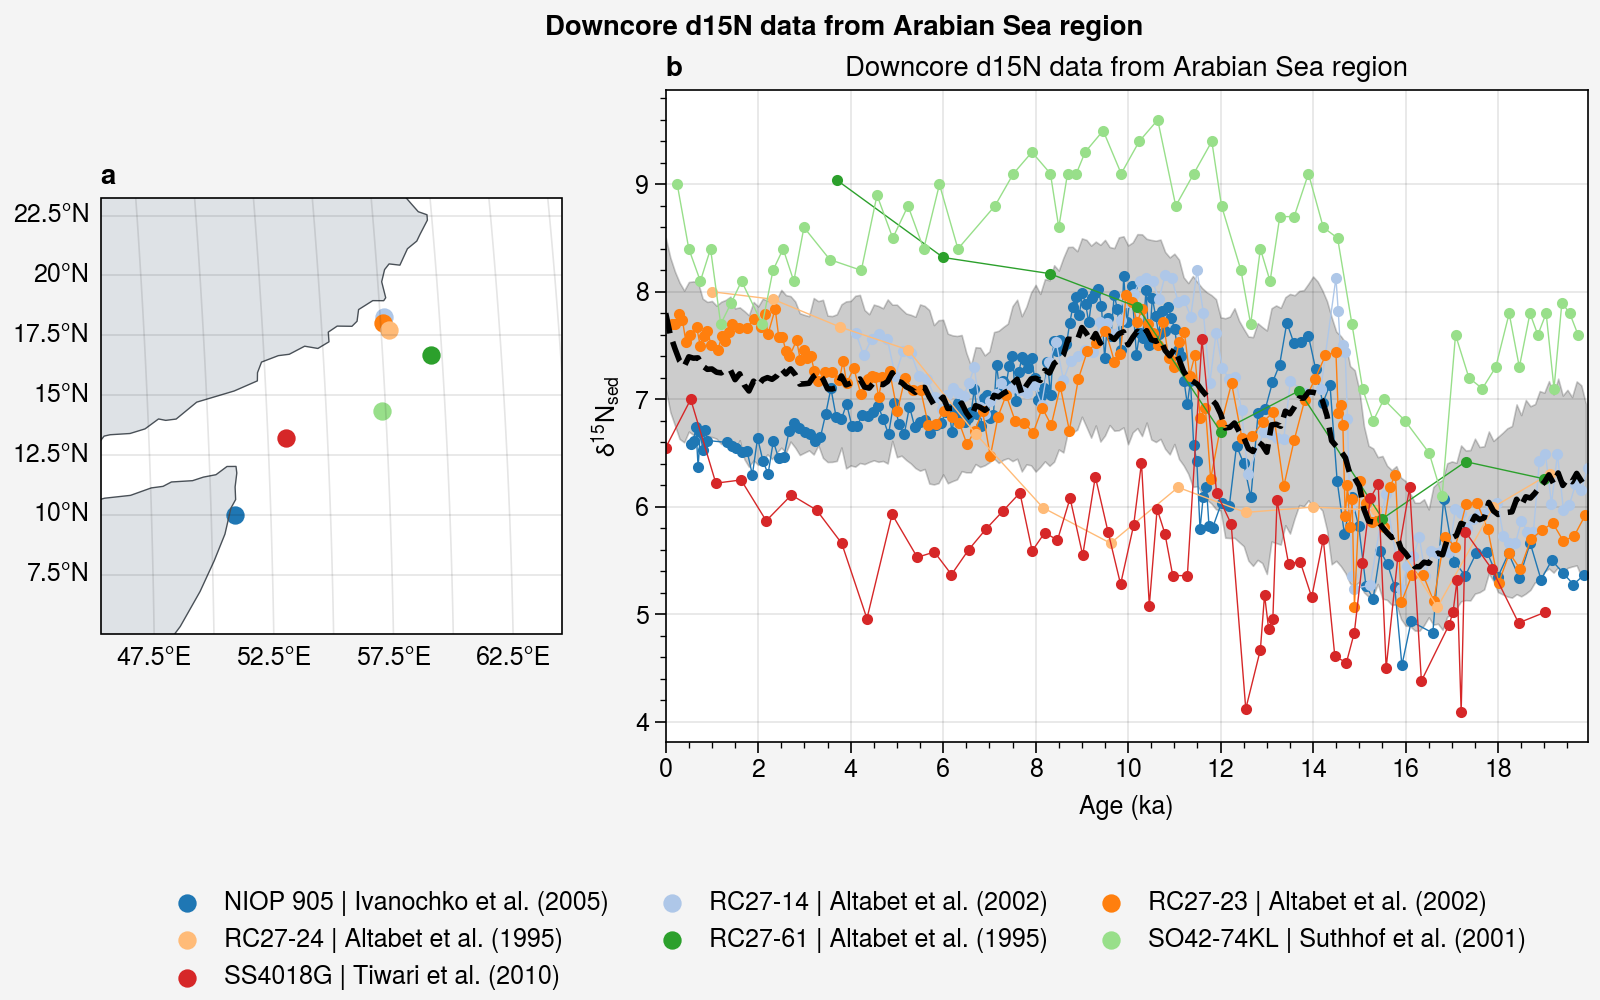

In [39]:
fig, axs = plot.subplots(figsize=(8,5),
                         ncols=2,share=0,
                         proj=('eck3',None),
                         wratios=[1,2])
### plot downcore d15N data only from Arabian Sea regions
plot_data = downcore_d15N_df[downcore_d15N_df['Latitude'].between(0,30)
                             & downcore_d15N_df['Longitude'].between(40,60)].dropna(subset=['Age','d15N'])
plot_data = plot_data[plot_data['Age']<20]
ax = axs[0]
ax.format(land=True, landcolor='gray3', landzorder=0,
        coast=True, coastcolor='gray7', coastlinewidth=0.5, coastzorder=1,
        latlabels=True, lonlabels=True,
        latlim=(plot_data['Latitude'].min()-5,plot_data['Latitude'].max()+5),
        lonlim=(plot_data['Longitude'].min()-5,plot_data['Longitude'].max()+5),
        )

grouped = plot_data.groupby('core_name')
for name, group in grouped:
    group = group.reset_index(drop=True)
    max_age = group['Age'].max()
    if max_age>15:
        plot_lat = group['Latitude'].unique()
        plot_lon = group['Longitude'].unique()
        ref_name = group['ref'].unique()
        ax.scatter(plot_lon,plot_lat,
                label=name+' | '+ref_name,cycle='tab20')
h,l = ax.get_legend_handles_labels()
fig.legend(h,l,ncol=3,loc='b',
          bbox_to_anchor=(0.5,-0.2),frameon=False)

ax = axs[1]
grouped = plot_data.groupby('core_name')
for name, group in grouped:
    group = group.reset_index(drop=True)
    max_age = group['Age'].max()    
    if max_age>15:
        ax.plot(group['Age'],group['d15N'],
                m='.',lw=0.5,
                label=name,cycle='tab20')
### plot rolling mean of d15N data 
rolling_age_widow = 0.5
age_range = np.arange(0,20,0.1)
rolling_mean = pd.DataFrame()
rolling_mean['Age'] = age_range
rolling_mean['d15N'] = np.nan
rolling_mean['d15N_std'] = np.nan
rolling_mean['d15N_median'] = np.nan    
for i in range(len(age_range)):
    age = age_range[i]
    rolling_mean['d15N'][i] = plot_data[(plot_data['Age']>=age-rolling_age_widow)
                                        & (plot_data['Age']<=age+rolling_age_widow)]['d15N'].mean()
    rolling_mean['d15N_std'][i] = plot_data[(plot_data['Age']>=age-rolling_age_widow)
                                                & (plot_data['Age']<=age+rolling_age_widow)]['d15N'].std()
    rolling_mean['d15N_median'][i] = plot_data[(plot_data['Age']>=age-rolling_age_widow)
                                        & (plot_data['Age']<=age+rolling_age_widow)]['d15N'].median()
plot_x = rolling_mean['Age']
plot_y = rolling_mean['d15N']
ax.plot(plot_x,plot_y,c='k',lw=2,label='rolling mean',ls='--')
ax.fill_between(plot_x,plot_y-rolling_mean['d15N_std'],plot_y+rolling_mean['d15N_std'],color='k',alpha=0.2)

ax.format(
        xlabel='Age (ka)',
        ylabel=r'$\delta^{15}$N$_{sed}$',
        xlocator=range(0,20,2),
        ylocator=1,
        title='Downcore d15N data from Arabian Sea region',
        suptitle='Downcore d15N data from Arabian Sea region',
)


## Fig. 5: Paleo case study - Tasman Sea

In [40]:
fpath = fr'{local_github_path}/spreadsheets/'
fname = 'ds07_TasmanSea_paleorecords.xlsx'

slope = ols_tex_thermoT_thisStudy.coef_[0]
intercept = ols_tex_thermoT_thisStudy.intercept_

#################
DSDP591_uk37_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_Alkenone_Data',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_Alkenone_Data',skiprows=2).iloc[0,:].values
DSDP591_uk37_df.columns = header
DSDP591_uk37_df = DSDP591_uk37_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                  'Age 1':'Age_ka',
                                                  'Age 2':'Age2_ka',
                                                  "UK37'":'uk37',
                                                  'BAYSPLINE-derived SST':'SST_bayspline',
                                                  "UK37 Total":'uk37_conc_ng_g'})
features = ['Depth_mbsf','Age_ka','uk37','SST_bayspline','uk37_conc_ng_g']
DSDP591_uk37_df = DSDP591_uk37_df[features].dropna(subset=['uk37','SST_bayspline','uk37_conc_ng_g'])
display(DSDP591_uk37_df.head())

#################
DSDP591_tex86_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_GDGT_Data',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_GDGT_Data',skiprows=2).iloc[0,:].values
DSDP591_tex86_df.columns = header
DSDP591_tex86_df = DSDP591_tex86_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                  'Age 1':'Age_ka',
                                                  'Age 2':'Age2_ka',})
DSDP591_tex86_df['sst_new'] = (DSDP591_tex86_df['TEX86']-intercept)/slope
display(DSDP591_tex86_df.head())

#################
IODPU1510_uk37_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_Alkenone_Data',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_Alkenone_Data',skiprows=2).iloc[0,:].values
IODPU1510_uk37_df.columns = header
IODPU1510_uk37_df = IODPU1510_uk37_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                  'Age 1':'Age_ka',
                                                  'Age 2':'Age2_ka',
                                                  "UK37'":'uk37',
                                                  'BAYSPLINE-derived SST':'SST_bayspline',
                                                  "UK37 Total":'uk37_conc_ng_g'})
features = ['Depth_mbsf','Age_ka','uk37','SST_bayspline','uk37_conc_ng_g']
IODPU1510_uk37_df = IODPU1510_uk37_df[features].dropna(subset=['uk37','SST_bayspline','uk37_conc_ng_g'])
display(IODPU1510_uk37_df.head())

################
IODPU1510_tex86_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_GDGT_Data',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_GDGT_Data',skiprows=2).iloc[0,:].values
IODPU1510_tex86_df.columns = header
IODPU1510_tex86_df = IODPU1510_tex86_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                  'Age 1':'Age_ka',
                                                  'Age 2':'Age2_ka',})
IODPU1510_tex86_df['sst_new'] = (IODPU1510_tex86_df['TEX86']-intercept)/slope
display(IODPU1510_tex86_df.head())


Depth_mbsf  Age_ka  uk37  SST_bayspline  uk37_conc_ng_g
1        0.08    3.73  0.78          21.57           60.14
2        0.13    6.07  0.78          21.61           55.22
3        0.15    7.00  0.78          21.52           42.35
4        0.21    9.80  0.76          20.90           51.55
5        0.26   12.13  0.75          20.71           51.65

Leg/Exp   Site Hole  Core Type  Section  Interval top  Interval bottom  \
0      90 591.00    *  1.00    H     1.00          0.00             3.00   
1      90 591.00    *  1.00    H     1.00          7.00             9.00   
2      90 591.00    *  1.00    H     1.00         12.00            14.00   
3      90 591.00    *  1.00    H     1.00         14.00            16.00   
4      90 591.00    *  1.00    H     1.00         20.00            22.00   

   Depth_mbsf  NaN  ...  BIT   MI %GDGT-0  GDGT-0/Cren  GDGT-2/Cren  \
0        0.01  NaN  ... 0.07 0.22   35.97         0.56         0.15   
1        0.08  NaN  ... 0.04 0.22   34.74         0.53         0.15   
2        0.13  NaN  ... 0.05 0.22   31.22         0.45         0.15   
3        0.15  NaN  ... 0.05 0.23   33.11         0.49         0.16   
4        0.21  NaN  ... 0.24 0.21   33.49         0.50         0.14   

   GDGT-2/GDGT-3  RI (TEX)  RI (Sample)  DRI  sst_new  
0           6.64      2.57         2.49 0.08    28.07  
1           6.74      2.46         2.51 0.05    25.67  
2           7.33      2.46         2.62 0.15    25.69  
3           7.05      2.51         2.56 0.05    26.69  
4           6.72      2.56         2.57 0.02    27.87  

[5 rows x 56 columns]

Depth_mbsf  Age_ka  uk37  SST_bayspline  uk37_conc_ng_g
0        0.07    1.47  0.63          17.13           83.57
1        0.26    5.44  0.70          19.08           58.19
2        0.39    8.16  0.67          18.33           85.35
3        0.48   10.05  0.66          17.93          117.04
4        0.60   12.56  0.65          17.61          174.61

Leg/Exp   Site Hole  Core Type  Section  Interval top  Interval bottom  \
0     371  U1510    A  1.00    H     1.00          6.00             8.00   
1     371  U1510    A  1.00    H     1.00         25.00            27.00   
2     371  U1510    A  1.00    H     1.00         38.00            40.00   
3     371  U1510    A  1.00    H     1.00         47.00            49.00   
4     371  U1510    A  1.00    H     1.00         59.00            61.00   

   Depth_mbsf  NaN  ...  BIT   MI %GDGT-0  GDGT-0/Cren  GDGT-2/Cren  \
0        0.07  NaN  ... 0.03 0.20   40.02         0.67         0.11   
1        0.26  NaN  ... 0.29 0.21   39.18         0.64         0.13   
2        0.39  NaN  ... 0.22 0.22   39.88         0.66         0.13   
3        0.48  NaN  ... 0.07 0.20   37.34         0.60         0.12   
4        0.60  NaN  ... 0.09 0.24   43.78         0.78         0.14   

   GDGT-2/GDGT-3  RI (TEX)  RI (Sample)  DRI  sst_new  
0           7.65      2.19         2.32 0.13    18.70  
1           6.69      2.34         2.37 0.03    22.63  
2           6.11      2.28         2.33 0.05    21.11  
3           8.57      2.27         2.41 0.14    20.92  
4           8.45      2.19         2.19 0.00    18.68  

[5 rows x 56 columns]

In [41]:
### read LR04_benthic_stack data
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'lisiecki2005-d18o-stack-noaa.txt'
with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if not line.startswith('#'):
        break
    
data = lines[i+1:]
header = ['Age_kyrBP','d18O_benthic','d18O_benthic_error']
data = [line.split() for line in data]
LR04_benthic_df = pd.DataFrame(data,columns=header)
LR04_benthic_df = LR04_benthic_df.apply(pd.to_numeric,errors='ignore')
LR04_benthic_df

Age_kyrBP  d18O_benthic  d18O_benthic_error
0          0.00          3.23                0.03
1          1.00          3.23                0.04
2          2.00          3.18                0.03
3          3.00          3.29                0.03
4          4.00          3.30                0.03
...         ...           ...                 ...
2110    5300.00          2.91                0.06
2111    5305.00          2.79                0.04
2112    5310.00          2.79                0.09
2113    5315.00          2.84                0.07
2114    5320.00          2.91                0.09

[2115 rows x 3 columns]

In [42]:
#### read vostok atmospheric d18O data
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'deutnat-vostok-noaa.txt'

with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if i == 0:
        continue
    else:
        if not line.startswith('#'):
            break
    
data = lines[i+1:]
header = ['depth_m','ice_ageBP','deltaD','deltaTS']
data = [line.split() for line in data]
Vostok_deltaTS_df = pd.DataFrame(data,columns=header)
Vostok_deltaTS_df = Vostok_deltaTS_df.apply(pd.to_numeric,errors='ignore')
Vostok_deltaTS_df['Age_kaBP'] = Vostok_deltaTS_df['ice_ageBP']/1000
Vostok_deltaTS_df

depth_m  ice_ageBP  deltaD  deltaTS  Age_kaBP
0           0          0 -438.00     0.00      0.00
1           1         17 -438.00     0.00      0.02
2           2         35 -438.00     0.00      0.04
3           3         53 -438.00     0.00      0.05
4           4         72 -438.00     0.00      0.07
...       ...        ...     ...      ...       ...
3306     3306     420281 -435.20     0.54    420.28
3307     3307     420888 -436.40     0.32    420.89
3308     3308     421507 -437.30     0.15    421.51
3309     3309     422135 -437.60     0.08    422.13
3310     3310     422766 -436.60     0.23    422.77

[3311 rows x 5 columns]

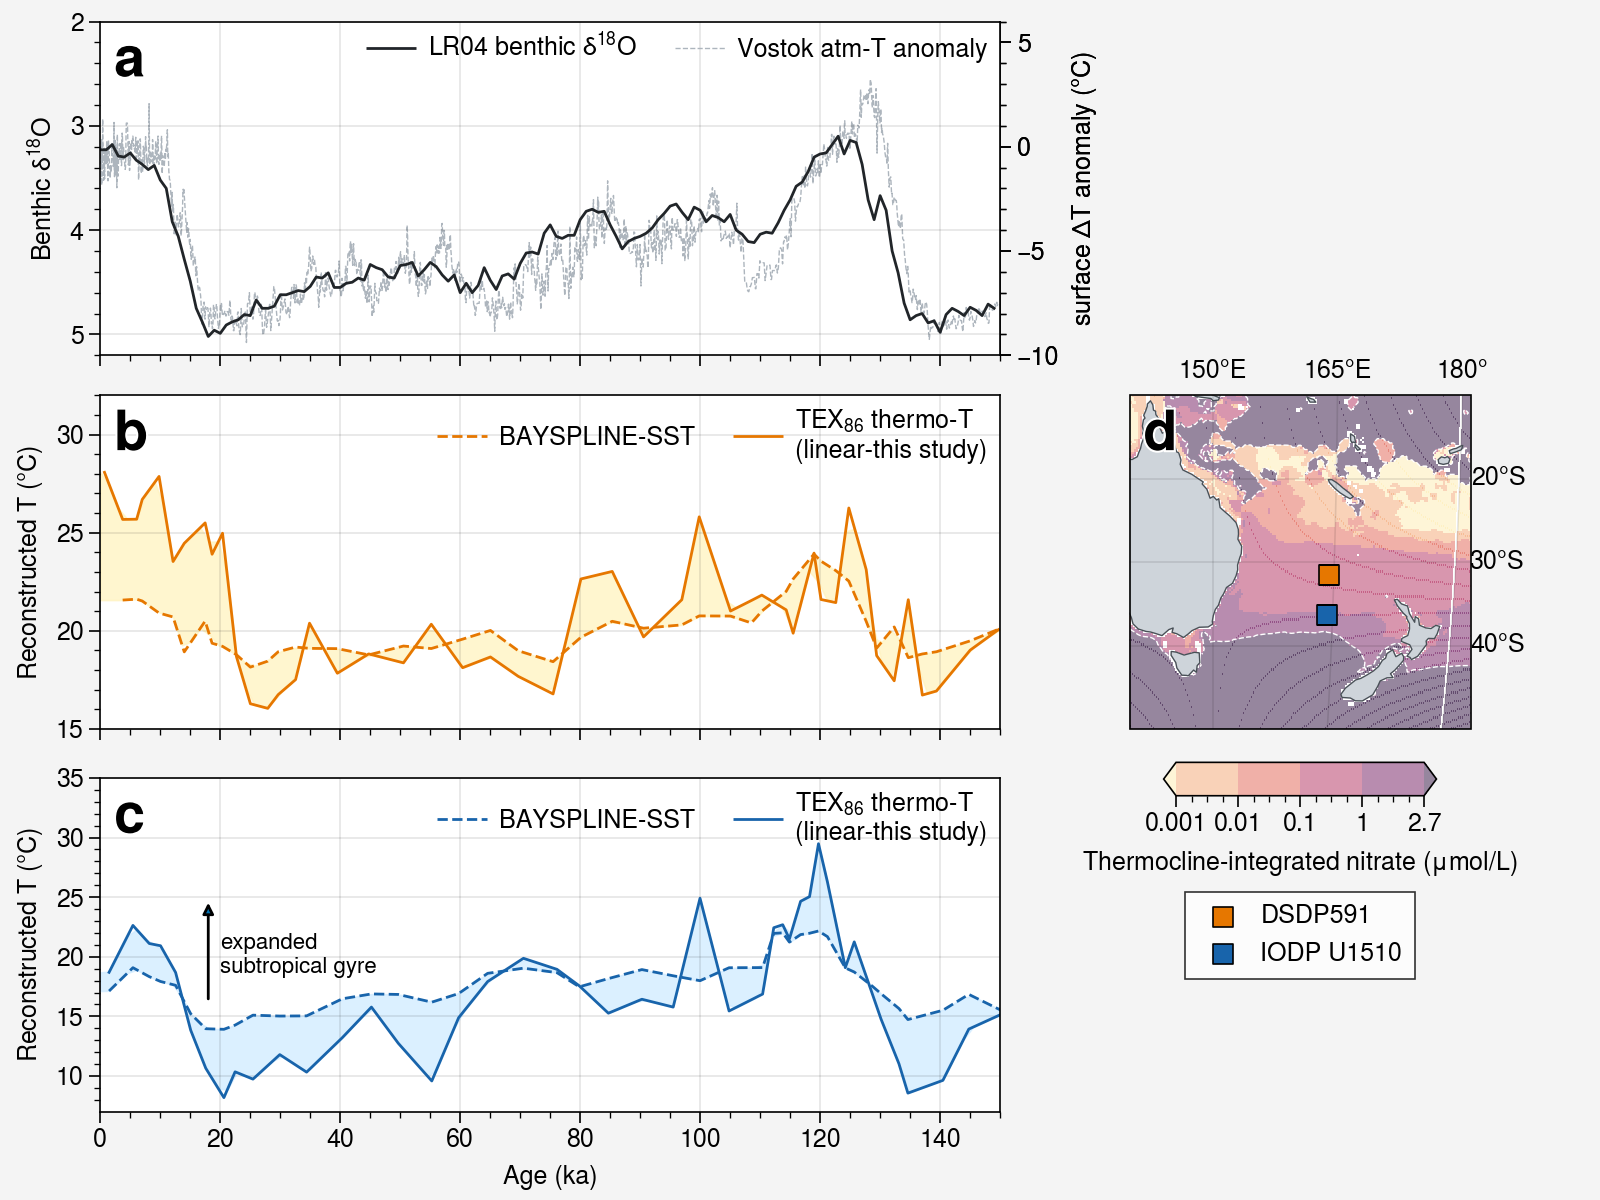

In [43]:
array = [
    [1,1,1,0,0],
    [2,2,2,4,4],
    [3,3,3,0,0],
]
fig, axs = plot.subplots(
    array,
    figsize=(8,6),
    sharey=0,
    proj=(None,None,None,'eck3'),
    proj_kw={'lon_0': 150}
    )
#### plot LR04 benthic d18O
ax = axs[0]

ax2 = ax.twinx()
plot_data = Vostok_deltaTS_df[Vostok_deltaTS_df['Age_kaBP']<150]
plot_x = plot_data['Age_kaBP']
plot_y = plot_data['deltaTS']
ax2.plot(plot_x,plot_y,lw=0.5,c='gray5',ls='--',label='Vostok atm-T anomaly')
ax2.format(
    ylim=(-10,6),
    ylabel='surface $\Delta$T anomaly ($\degree$C)',
)


plot_data = LR04_benthic_df[LR04_benthic_df['Age_kyrBP']<150]
plot_x = plot_data['Age_kyrBP']
plot_y = plot_data['d18O_benthic']
ax.plot(plot_x,plot_y,lw=1,c='gray9',label = 'LR04 benthic $\delta^{18}$O')
ax.format(
    ylim=(5.2,2.0),
    ylabel='Benthic $\delta^{18}$O'
)


h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h+h2,l+l2,loc='ur',ncol=2,frameon=False)
ax.set_zorder(1)
ax2.set_zorder(0)
#### plot uk37-SST and tex86-SST as line plots on the same subplot for comparison 
ax = axs[1]
# #### plot uk_conc data as proxy for productivity
# ax2 = ax.twinx()
# plot_data = DSDP591_uk37_df.dropna(subset=['uk37_conc_ng_g']).sort_values(by='Age_ka').reset_index(drop=True)
# plot_x = plot_data['Age_ka']
# plot_y = plot_data['uk37_conc_ng_g']
# ax2.plot(plot_x,plot_y,lw=0.5,c='gray7',ls=':')
# ax2.format(
#     yscale='log',
# )

plot_data = DSDP591_uk37_df.dropna(subset=['SST_bayspline']).sort_values(by='Age_ka').reset_index(drop=True)
plot_x1 = plot_data['Age_ka']
plot_y1 = plot_data['SST_bayspline']
ax.plot(plot_x1,plot_y1,label='BAYSPLINE-SST',c='yellow9',lw=1,ls='--')

plot_data = DSDP591_tex86_df[
    ((DSDP591_tex86_df['BIT']<=0.5)
    &(DSDP591_tex86_df['MI']<=0.5)
    &(DSDP591_tex86_df['%GDGT-0']<=60))].dropna(subset=['sst_new']).sort_values(by='Age_ka').reset_index(drop=True)
plot_x2 = plot_data['Age_ka']
plot_y2 = plot_data['sst_new']
ax.plot(plot_x2,plot_y2,label='TEX$_{86}$ thermo-T\n(linear-this study)',lw=1,c='yellow9')


### shade color between y of two lines ---if tex is higher than uk37, shade red else shade blue
### need to interpolate the two lines to get the y values at the same x

x = np.linspace(0,150,100)
y1 = np.interp(x,plot_x1,plot_y1)
y2 = np.interp(x,plot_x2,plot_y2)
ax.fill_between(x,y1,y2,color='yellow1',alpha=0.75)


h, l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='ur',ncol=2,frameon=False)

ax.format(
    ylim=(15,32),
    ylabel='Reconstructed T ($\degree$C)',
)



#####################################################

ax = axs[2]
# #### plot uk_conc data as proxy for productivity
# ax2 = ax.twinx()
# plot_data = IODPU1510_uk37_df.dropna(subset=['uk37_conc_ng_g']).sort_values(by='Age_ka').reset_index(drop=True)
# plot_x = plot_data['Age_ka']
# plot_y = plot_data['uk37_conc_ng_g']
# ax2.plot(plot_x,plot_y,lw=0.5,c='gray7',ls=':')
# ax2.format(
#     yscale='log',
# )

plot_data = IODPU1510_uk37_df.dropna(subset=['SST_bayspline']).sort_values(by='Age_ka').reset_index(drop=True)
plot_x1 = plot_data['Age_ka']
plot_y1 = plot_data['SST_bayspline']
ax.plot(plot_x1,plot_y1,label='BAYSPLINE-SST',lw=1,c='blue9',ls='--')

plot_data = IODPU1510_tex86_df[
    ((IODPU1510_tex86_df['BIT']<=0.5)
    &(IODPU1510_tex86_df['MI']<=0.5)
    &(IODPU1510_tex86_df['%GDGT-0']<=60))].dropna(subset=['sst_new']).sort_values(by='Age_ka').reset_index(drop=True)
plot_x2 = plot_data['Age_ka']
plot_y2 = plot_data['sst_new']
ax.plot(plot_x2,plot_y2,label='TEX$_{86}$ thermo-T\n(linear-this study)',lw=1,c='blue9')

### shade pale yellow between y of two lines
### need to interpolate the two lines to get the y values at the same x
x = np.linspace(0,150,100)
y1 = np.interp(x,plot_x1,plot_y1)
y2 = np.interp(x,plot_x2,plot_y2)
ax.fill_between(x,y1,y2,color='blue1',alpha=0.75)

h, l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='ur',ncol=2,frameon=False)


ax.format(
    ylim=(7,35),
    ylabel='Reconstructed T ($\degree$C)',
)

#### add an arrow with annotation showing reduced denitrification during YD and HS1
ax.annotate('',
            xy=(18,16),xytext=(18,25),
            arrowprops=dict(arrowstyle='<|-',lw=1),
            ha='center',va='center',fontsize=8)
ax.text(20,22,'expanded\nsubtropical gyre',
        ha='left',va='top',fontsize=8)


####################################################
ax = axs[3]
ax.format(
    land=True,landcolor='gray4',landzorder=0,
    coast=True,coastcolor='gray7',coastlinewidth=0.5,
    latlim=(-50,-10),lonlim=(-220,-179),
    latlines=10,lonlines=15,
    latlabels='r',lonlabels='t',
)

# ### plot gridded tex residuals
# plot_data = gridded_coretop_ds.tex_residuals.sel(lat=slice(-60,-10)).to_dataframe().reset_index()
# plot_data = plot_data.dropna(subset=['tex_residuals'])
# plot_x = plot_data['lon']
# plot_y = plot_data['lat']
# plot_c = plot_data['tex_residuals']
# m = ax.scatter(plot_x,plot_y,
#                c=plot_c,cmap='balance',
#                m='o',s=50,mec='k',
#                vmin=-0.5,vmax=0.5,
#                zorder=2)

### plot thermocline-integrated nitrate on the map
m=thermocline_nitrate_da.sel(lat=slice(-60,-10)).plot(ax=ax,
                                                    zorder=0,
                                                    levels=[1e-3,1e-2,1e-1,1,lowno3_threshold],
                                                    cmap='matter',
                                                    add_colorbar=False,
                                                    alpha=0.5,
                                                    rasterized=True)


### plot contour line for lowno3_threshold μM nitrate
thermocline_nitrate_da.sel(lat=slice(-60,-10)).plot.contour(ax=ax,levels=[0,lowno3_threshold],
                                                zorder=1,
                                                linewidths=0.5,
                                                linestyles='dashed',
                                                colors='w',robust=True)

ax.set_title('')

axins1 = inset_axes(
    ax,
    width="80%",
    height="10%",
    loc="lower center",
    bbox_to_anchor=(0,-0.2,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             label='Thermocline-integrated nitrate ($\mu$mol/L)',
             extend='both'
             )
axins1.xaxis.set_ticklabels(['0.001','0.01','0.1','1',f'{lowno3_threshold}'])
### lat/lon for DSDP591 = -31.5843	 164.4487
### lat/lon for IODP U1510 = 36°19.7385′S, 164°33.5220′E, water depth 1238 m

ax.scatter(164.4487,-31.5843,c='yellow9',
           mec='k',marker='s',s=50,
           label='DSDP591',
           zorder=2)

ax.scatter(164.33,-36.33,c='blue9',
              mec='k',marker='s',s=50,
              label='IODP U1510',
              zorder=2)

h, l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='lower center',ncol=1,
          bbox_to_anchor=(0,-0.75,1,1),
          )
axs[:3].format(
    xlim=(0,150),
    xlabel='Age (ka)',
)

axs.format(
    abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20},
)



fpath = fr'{local_github_path}/figures/'
fname = 'paleo_showcase_SPSTG.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',dpi=1440)

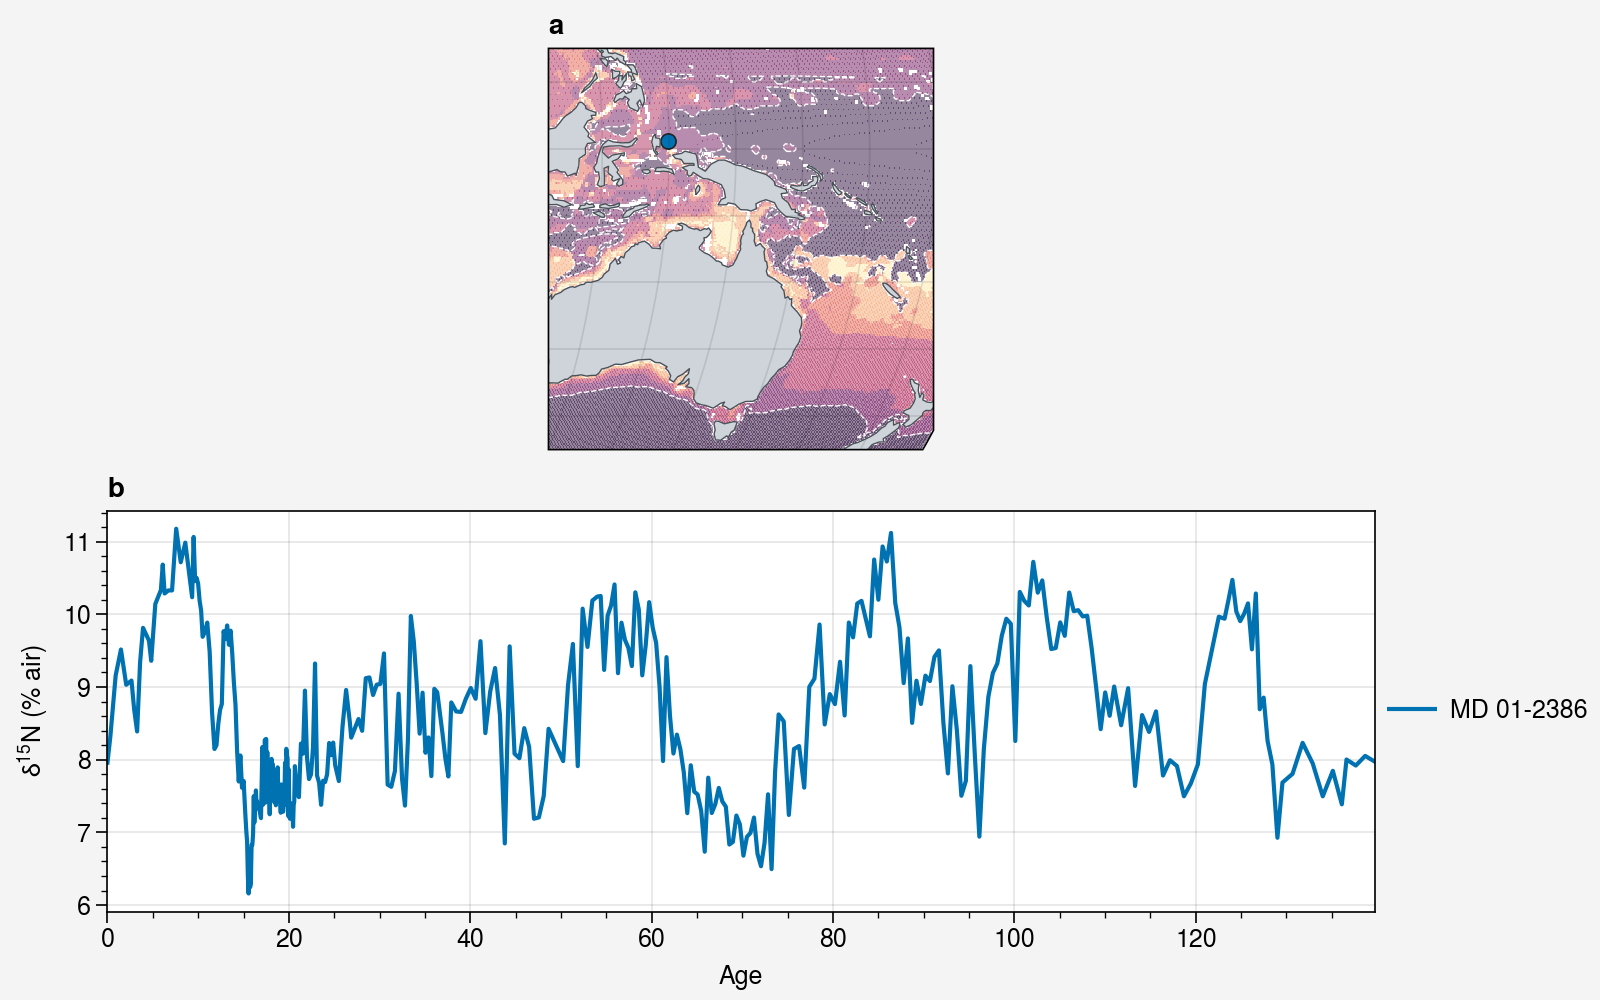

In [44]:
fig, axs = plot.subplots(figsize=(8,5),
                            nrows=2,share=0,
                            proj=('eck3',None),)

### plot sites with downcore d15N data
ax = axs[0]
ax.format(
    land=True,landcolor='gray4',landzorder=0,
    coast=True,coastcolor='gray7',coastlinewidth=0.5,
    latlim=(-45,15),lonlim=(120,170),
)

### plot nitrate concentration contours
m = thermocline_nitrate_da.sel(lat=slice(-45,15),lon=slice(100,180)).plot(ax=ax,
                                                                        zorder=0,
                                                                        levels=[1e-3,1e-2,1e-1,1,lowno3_threshold],
                                                                        cmap='matter',
                                                                        add_colorbar=False,
                                                                        alpha=0.5,
                                                                        rasterized=True)

### plot the lowno3_threshold μM contour line
thermocline_nitrate_da.sel(lat=slice(-45,15),lon=slice(100,180)
                                       ).plot.contour(ax=ax,levels=[0,lowno3_threshold],
                                                        zorder=1,
                                                        linewidths=0.5,
                                                        linestyles='dashed',
                                                        colors='w',robust=True)

# plot_data = downcore_d15N_siteInfo_df
# plot_lat = plot_data['lat']
# plot_lon = plot_data['lon']
# ax.scatter(plot_lon,plot_lat,
#            c='gray7',marker='o',mec='gray9',s=30,
#            label='Downcore $\delta^{15}$N sites')

#### plot d15N data time series within lat lon range
ax = axs[1]
ax.format(
    ylabel='$\delta^{15}$N (% air)',
    # ylim=(3,10.5)
)

plot_data = downcore_d15N_df[downcore_d15N_df['core_name'].isin(['MD 01-2386'])
                             ].dropna(subset=['Age','d15N']).reset_index(drop=True)
plot_data = plot_data[plot_data['Age']<140]

grouped = plot_data.groupby('core_name')
for name, group in grouped:
    group = group.sort_values(by='Age').reset_index(drop=True)
    plot_age = group['Age']
    plot_d15N = group['d15N']
    ax.plot(plot_age,plot_d15N,label=name)
    
    plot_lat = group['Latitude'].unique()
    plot_lon = group['Longitude'].unique()
    axs[0].scatter(plot_lon,plot_lat,label=name,marker='o',mec='gray9',s=30)
    
h,l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='r',ncol=1,frameon=False)